# Aprendizado de Máquina com Duplo Desviés (*Double Debiased Machine Learning* - DDML)

Prof. Daniel de Abreu Pereira Uhr


### Conteúdo
* Introdução
* Pre-test
  * Quando o pre-test não é um problema?
  * Quando o pre-test é um problema?
* Viés de Variável Omitida (*Omitted Variable Bias - OVB*)
* Post-Double Selection (Seleção Pós-Dupla)
* Aprendizado de Máquina com Duplo Desviés (*Double Debiased Machine Learning*)
* Aplicação em Python



### Referências

* A. Belloni, D. Chen, V. Chernozhukov, C. Hansen, Sparse Models and Methods for Optimal Instruments With an Application to Eminent Domain (2012), Econometrica.
* A. Belloni, V. Chernozhukov, C. Hansen, Inference on treatment effects after selection among high-dimensional controls (2014), The Review of Economic Studies.
* V. Chernozhukov, D. Chetverikov, M. Demirer, E. Duflo, C. Hansen, W. Newey, J. Robins, Double/debiased machine learning for treatment and structural parameters (2018), The Econometrics Journal.
* P. Hünermund, B. Louw, I. Caspi, Double Machine Learning and Automated Confounder Selection - A Cautionary Tale (2022), working paper.



***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

Configuração do sistema


In [12]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')
# Importar statsmodels formula.api
import statsmodels.formula.api as smf
# numpy e pandas
import numpy as np
import pandas as pd

lembrete: se ao carregar os dados abaixo der erro ("*ConnectionResetError*"), rode novamente até carregar.

In [4]:
import types
import sys
import requests

# Cria um módulo fictício chamado 'dgp' na memória do computador
dgp_module = types.ModuleType("dgp")

# Executa o conteúdo de dgp.py e coloca dentro do módulo 'dgp'
dgp_code = requests.get("https://raw.githubusercontent.com/Daniel-Uhr/ComputationalEconomics_Notes/main/dgp/dgp.py").text
exec(dgp_code, dgp_module.__dict__)

# Registra o módulo no sys.modules para que outros códigos possam importá-lo
sys.modules["dgp"] = dgp_module

In [6]:
# Agora podemos carregar dgp_collection.py que depende de 'from dgp import DGP'
collection_code = requests.get("https://raw.githubusercontent.com/Daniel-Uhr/ComputationalEconomics_Notes/main/dgp/dgp_collection.py").text
exec(collection_code)

Você deve ter instalado no seu kernel as seguintes bibliotecas para que possamos rodar a programação de figuras que vamos carregar: 

`pip instal binsreg`

`pip install fig`

`pip install gif`

In [7]:
figures = requests.get("https://raw.githubusercontent.com/Daniel-Uhr/ComputationalEconomics_Notes/main/dgp/figures.py").text
exec(figures)

In [8]:
theme = requests.get("https://raw.githubusercontent.com/Daniel-Uhr/ComputationalEconomics_Notes/main/dgp/theme.py").text
exec(theme)

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Introdução

Em um experimento controlado e aleatorizado (*Randomized Controlled Trial* - RCT), o tratamento ($D$) é aleatoriamente atribuído aos participantes, o que permite que os pesquisadores isolem o efeito do tratamento sobre o resultado. E o uso de variáveis de controle ($X$) é geralmente desnecessário, pois a aleatorização garante que os grupos de tratamento e controle sejam comparáveis em todas as características observadas e não observadas. Logo, a utilização das variáveis de controle teria um papel secundário, como o de aumentar o poder estatístico da análise, ao reduzir a variância do estimador.

Entretanto, em estudos observacionais, onde não há aleatorização do tratamento, o uso de variáveis de controle torna-se essencial para tentar recuperar os efeitos causais. Nesse contexto, as variáveis de controle são utilizadas para ajustar as diferenças pré-existentes entre os grupos de tratamento e controle, permitindo uma melhor aproximação do efeito causal.

Em muitos casos, principalmente nos últimos anos devido ao avanço computacional e de armazenagem de informação, o pesquisador dispõe de um grande número de variáveis de controle (*eventualmente, um numero de variáveis maior que o tamanho da amostra*), e surge a necessidade de selecionar aquelas mais relevantes, eventualmente capturando não linearidades e interações. Algoritmos de aprendizado de máquina são particularmente adequados para essa tarefa. No entanto, nesses casos, podemos introduzir um viés chamado de regularização ou pré-teste (Regularization - Pre-test), ou viés de seleção de características. 

Nesta aula, examinaremos a origem desse viés e apresentaremos uma das soluções mais influentes na última década na interseção entre aprendizado de máquina e inferência causal: o **Aprendizado de Máquina com Duplo Desviés** (*Double Debiased Machine Learning - DDML*).

Nosso roteiro, antes de chegar no DDML, será:
* Pré-teste (Pre-test)
* Viés de Variável Omitida (*Omitted Variable Bias - OVB*)
* Post-Double Selection (Seleção Pós-Dupla)

### Pre-test (Pré-teste)

Tenha em mente que estamos no contexto de estudos observacionais, com muitas possiveis variáveis de controle, e o pesquisador está interessado em selecionar as variáveis de controle mais relevantes para incluir no modelo de regressão.

O ***viés de pre-test*** (também chamado de viés de Regularização, ou de Seleção de Características) ocorre quando ***o pesquisador utiliza as variáveis de controle para decidir, COM BASE NOS DADOS, quais delas incluir no modelo final***. Essa seleção pode ser feita, por exemplo, com base em:
* testes estatísticos (por exemplo, se a variável é estatísticamente significativa), 
* algoritmos de seleção de variáveis ou, 
* por meio de algoritmos de aprendizado de máquina com regularização.

Embora essas abordagens possam melhorar a qualidade da previsão, elas podem comprometer a validade da inferência causal. O motivo é que a seleção baseada nos dados *introduz dependência entre os estimadores e o processo de seleção*, violando pressupostos fundamentais da teoria da inferência estatística clássica.

Na prática, isso significa que:

* O estimador do efeito do tratamento ($\hat{\alpha}$ associado à $D$) torna-se enviesado;
* A estimativa de seu erro padrão também se torna inválida, dificultando a construção de intervalos de confiança confiáveis;
* Mesmo modelos lineares, como o OLS, sofrem com esse problema se a inclusão ou exclusão de variáveis for condicionada aos próprios dados.

Do ponto de vista do *Machine Learning*, este fenômeno é um exemplo de *overfitting* inferencial: o modelo se adapta tão bem aos dados observados que perde a validade fora da amostra ou sob pequenas perturbações nos dados.

A solução para esse problema começa com a separação clara entre modelos de previsão (com alta capacidade de ajuste e regularização) e modelos de inferência causal, que precisam ser robustos a esse tipo de viés.


***Exemplo***

Suponha que fomos contratados por uma empresa para identificar ​o efeito dos gastos com publicidade na receita. O proprietário da empresa quer responder a seguinte pergunta:

* Vale a pena investir em publicidade? 

Como especialistas, sabemos que há muitos fatores que podem influenciar as vendas. Vamos supor que para esse caso a literatura sugere que uma medida de gestão (*Management* - índice/medida de capacidade de gestão) da loja pode controlar todos esses possíveis fatores. Mas temos dúvidas em utilizá-la ou não.

Vejamos no python. Vamos gerar os dados, e carregá-lo.

In [13]:
class dgp_pretest():
    """
    Data Generating Process: pre-test bias
    """
    
    def generate_data(self, a=1, b=.3, c=3, N=1000, seed=1):
        np.random.seed(seed)
        
        # Management
        Manag = np.random.normal(5, 1, N)
        
        # Advertisement 
        ads = c*Manag + np.random.normal(-3, 1, N)
        
        # Sales
        sales = a*ads + b*Manag + np.random.normal(0, 1, N)
                
        # Generate the dataframe
        df = pd.DataFrame({'ads': ads, 'sales': sales, 'Manag': Manag})

        return df

In [14]:
dgp = dgp_pretest()
df = dgp.generate_data()
df

,ads,sales,Manag
0,16.719800,19.196620,6.624345
1,7.732222,9.287491,4.388244
2,10.923469,11.816906,4.471828
3,8.457062,9.024376,3.927031
4,13.085146,12.814823,5.865408
...,...,...,...
995,11.839250,12.532427,4.883556
996,5.729024,5.923178,2.722702
997,10.869467,12.197920,4.930375
998,13.708986,13.915125,5.353870


Temos um dataframe com 1000 observações (empresas diferentes) e 3 variáveis: vendas ($Sales$), gastos com publicidade ($ads$) e gestão ($Manag$).

***A pergunta que queremos responder é: qual é o efeito dos gastos com publicidade nas vendas?***

Basicamente, podemos modelar de 2 formas diferentes:

* **Modelo Curto**

$$ Sales_{i} = \theta + \alpha ads_{i} + \epsilon_{i} $$

* **Modelo Longo**

$$ Sales_{i} = \theta + \alpha ads_{i} + \beta Manag_{i} + \epsilon $$


Surge a dúvida, deveríamos controlar a gestão da firma? Ou seja, devemos incluir a variável $Manag$ no modelo? 

Como não temos certeza. Poderíamos deixar os ***dados decidirem***. Isto é, caso o coeficiente de $Manag$ seja estatisticamente significativo, incluímos a variável, e utilizamos o modelo longo. Caso contrário, utilizamos o modelo curto.

In [15]:
smf.ols('sales ~ ads + Manag', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1405,0.185,0.758,0.448,-0.223,0.504
ads,0.9708,0.030,32.545,0.000,0.912,1.029
Manag,0.3381,0.095,3.543,0.000,0.151,0.525


Segundo a regressão, o coeficiente de $Manag$ é positivo e estatisticamente significativo, então, seguindo o critério de significância estatística na regressão (Pre-Test), utilizamos o modelo longo.

### Viés de Variável Omitida (*Omitted Variable Bias - OVB*)

O procedimento anterior de Pre-test (Regularização, ou Seleção de Características) pode estar introduzindo um viés no estimador do efeito do tratamento ($\hat{\alpha}D$). Isso ocorre porque ***a decisão de incluir ou não a variável de controle foi tomada com base nos dados***, o que cria uma ***dependência entre o processo de seleção e o estimador***.


***Quando o pre-test não é um problema?***

Vamos realizar simulações para entender melhor a questão. No nosso caso, temos acesso ao processo gerador de dados (contrário do que ocorre na vida real). Então, vamos testar o que aconteceria se repetíssemos o procedimento várias vezes:

1. Extraimos uma nova amostra do processo de geração de dados;
2. Regredimos $Sales$ em $ads$ e $Manag$;
3. Se o coeficiente de $Manag$ for significativo no nível de 95%, mantemos o modelo longo.
4.  Caso contrário, regredimos $sales$ em $ads$ apenas (modelo curto), e mantemos esse coeficiente.

Ou seja, estamos testando o efeito de $Manag$ em $Sales$, mas o coeficiente de interesse é o de $ads$ ($\alpha$).

Mantenha em mente que a estimação correta dos coeficientes depende da especificação correta do modelo. E o modelo completo (modelo longo) é o correto, pois inclui todas as variáveis relevantes. Logo, o modelo curto seria uma especificação incorreta.

In [16]:
def pre_testing(d='ads', y='sales', x='Manag', K=1000, **kwargs):
    
    # Init
    alpha = {'Long': np.zeros(K), 'Short': np.zeros(K), 'Pre-test': np.zeros(K)}

    # Loop over simulations
    for k in range(K):
        
        # Generate data
        df = dgp_pretest().generate_data(seed=k, **kwargs)
        
        # Compute coefficients
        alpha['Long'][k] = smf.ols(f'{y} ~ {d} + {x}', df).fit().params[1]
        alpha['Short'][k] = smf.ols(f'{y} ~ {d}', df).fit().params[1]
    
        # Compute significance of beta
        p_value = smf.ols(f'{y} ~ {d} + {x}', df).fit().pvalues[2]
        
        # Select specification based on p-value
        if p_value<0.05:
            alpha['Pre-test'][k] = alpha['Long'][k]
        else:
            alpha['Pre-test'][k] = alpha['Short'][k]
    
    return alpha

alphas = pre_testing()

Agora podemos traçar as distribuições (por meio de simulações) dos coeficientes estimados.

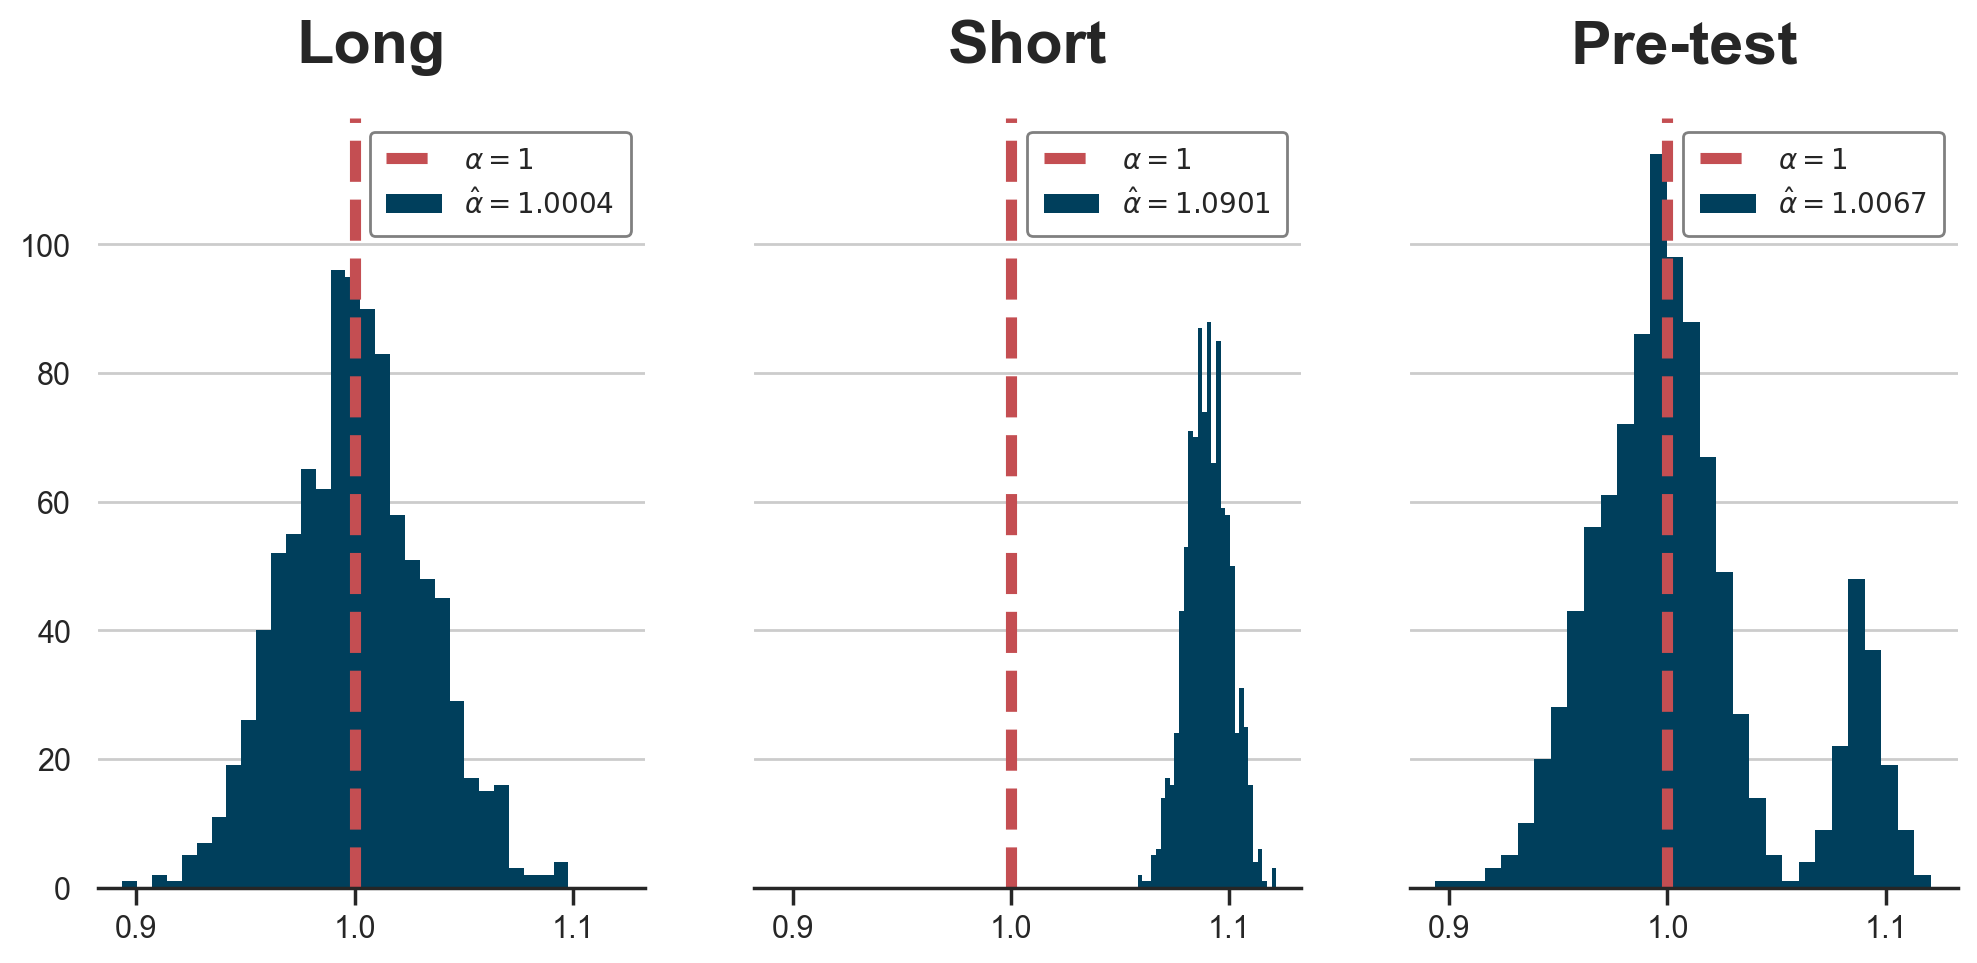

In [17]:
def plot_alphas(alphas, true_alpha):
    
    # Init plot
    fig, axes = plt.subplots(1, len(alphas), figsize=(4*len(alphas), 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.keys()):
        axes[i].hist(alphas[key], bins=30, lw=.1)
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        legend_text = [r'$\alpha=%.0f$' % true_alpha, r'$\hat \alpha=%.4f$' % np.mean(alphas[key])]
        axes[i].legend(legend_text, prop={'size': 10}, loc='upper right')

plot_alphas(alphas, true_alpha=1)

Podemos ver que no primeiro gráfico, se estivéssemos sempre executando a regressão longa, o coeficiente $\alpha_{long}$ seria não viesada e normalmente distribuída, enquanto o coeficiente $\alpha_{\text{short}}$ seria enviesado (tendencioso).

O procedimento de pre-test gera o estimador $\hat{\alpha}_{pre-test}$ que mistura os dois casos porque em algumas simulações o procedimento de pre-test seleciona o modelo curto, que é enviesado, e na maioria das vezes o modelo longo, que não é enviesado (como podemos ver no gráfico da direita). 

Então, o procedimento de pre-test ***distorce a inferência***, no caso, a distribuição do estimador $\hat{\alpha}_{pre-test}$ não é mais normal, mas bimodal. A consequencia disso é que os ***intervalos de confiança para o coeficiente terão intervalos errados*** (os intervalos conterão o efeito verdadeiro com uma probabilidade diferente da alegada).

***Quando o pre-test é um problema?***

O Pre-test é um problema quando executamos a regressão curta, e a variável de Gestão da Empresa (*Management*), que era relevante para o modelo, é omitida da estimação. Entramos no chamado ***Viés de Variável Omitida (*Omitted Variable Bias - OVB*)***.

Em geral, o OVB surge quando uma variável relevante (*Manag* ou $X$) para o modelo é omitida, e essa variável está correlacionada com a variável de interesse (no nosso caso, $ads$ ou $D$). Isso leva a uma estimativa enviesada do coeficiente da variável de interesse ($D$) sobre o resultado ($Y$).

Em termos de magnitude, o OVB pode ser expresso como:

$$ \text{OVB} = \beta \delta $$

onde

$$ \beta = \frac{\text{Cov}(X, Y)}{\text{Var}(X)} $$ 

e

$$ \delta = \frac{\text{Cov}(X, D)}{\text{Var}(X)} $$



onde $\beta$ é o efeito da variável omitida ($X$) no resultado ($Y$), e $\delta$ é o efeito da variável omitida ($X$) na variável de interesse ($D$).

O ***pre-test é um problema*** se:
* (i) rodamos uma regressão curta em vez da longa, e 
* (ii) o efeito do viés é sensível (tamanho da amostra? à magnitude do coeficiente?).

***O tamanho da amostra importa***

Como em algumas amostras o coeficiente de $Manag$ é não significativo, acabamos rodando a regressão curta, e o coeficiente $\hat{\alpha}_{short}$ é enviesado.

Uma forma de rejeitar corretamente a hipótese de que $H_{0}: \beta  = 0$ é que o tamanho da amostra seja maior. 

Com mais observações podemos estimar com mais precisão e será menos provavel cometer um erro tipo II (não rejeitar a hipótese nula quando ela é falsa), ou seja, executar a regressão curta quando deveríamos ter executado a longa.

Vamos simular o coeficiente estimado sob diferentes tamanhos de amostra.

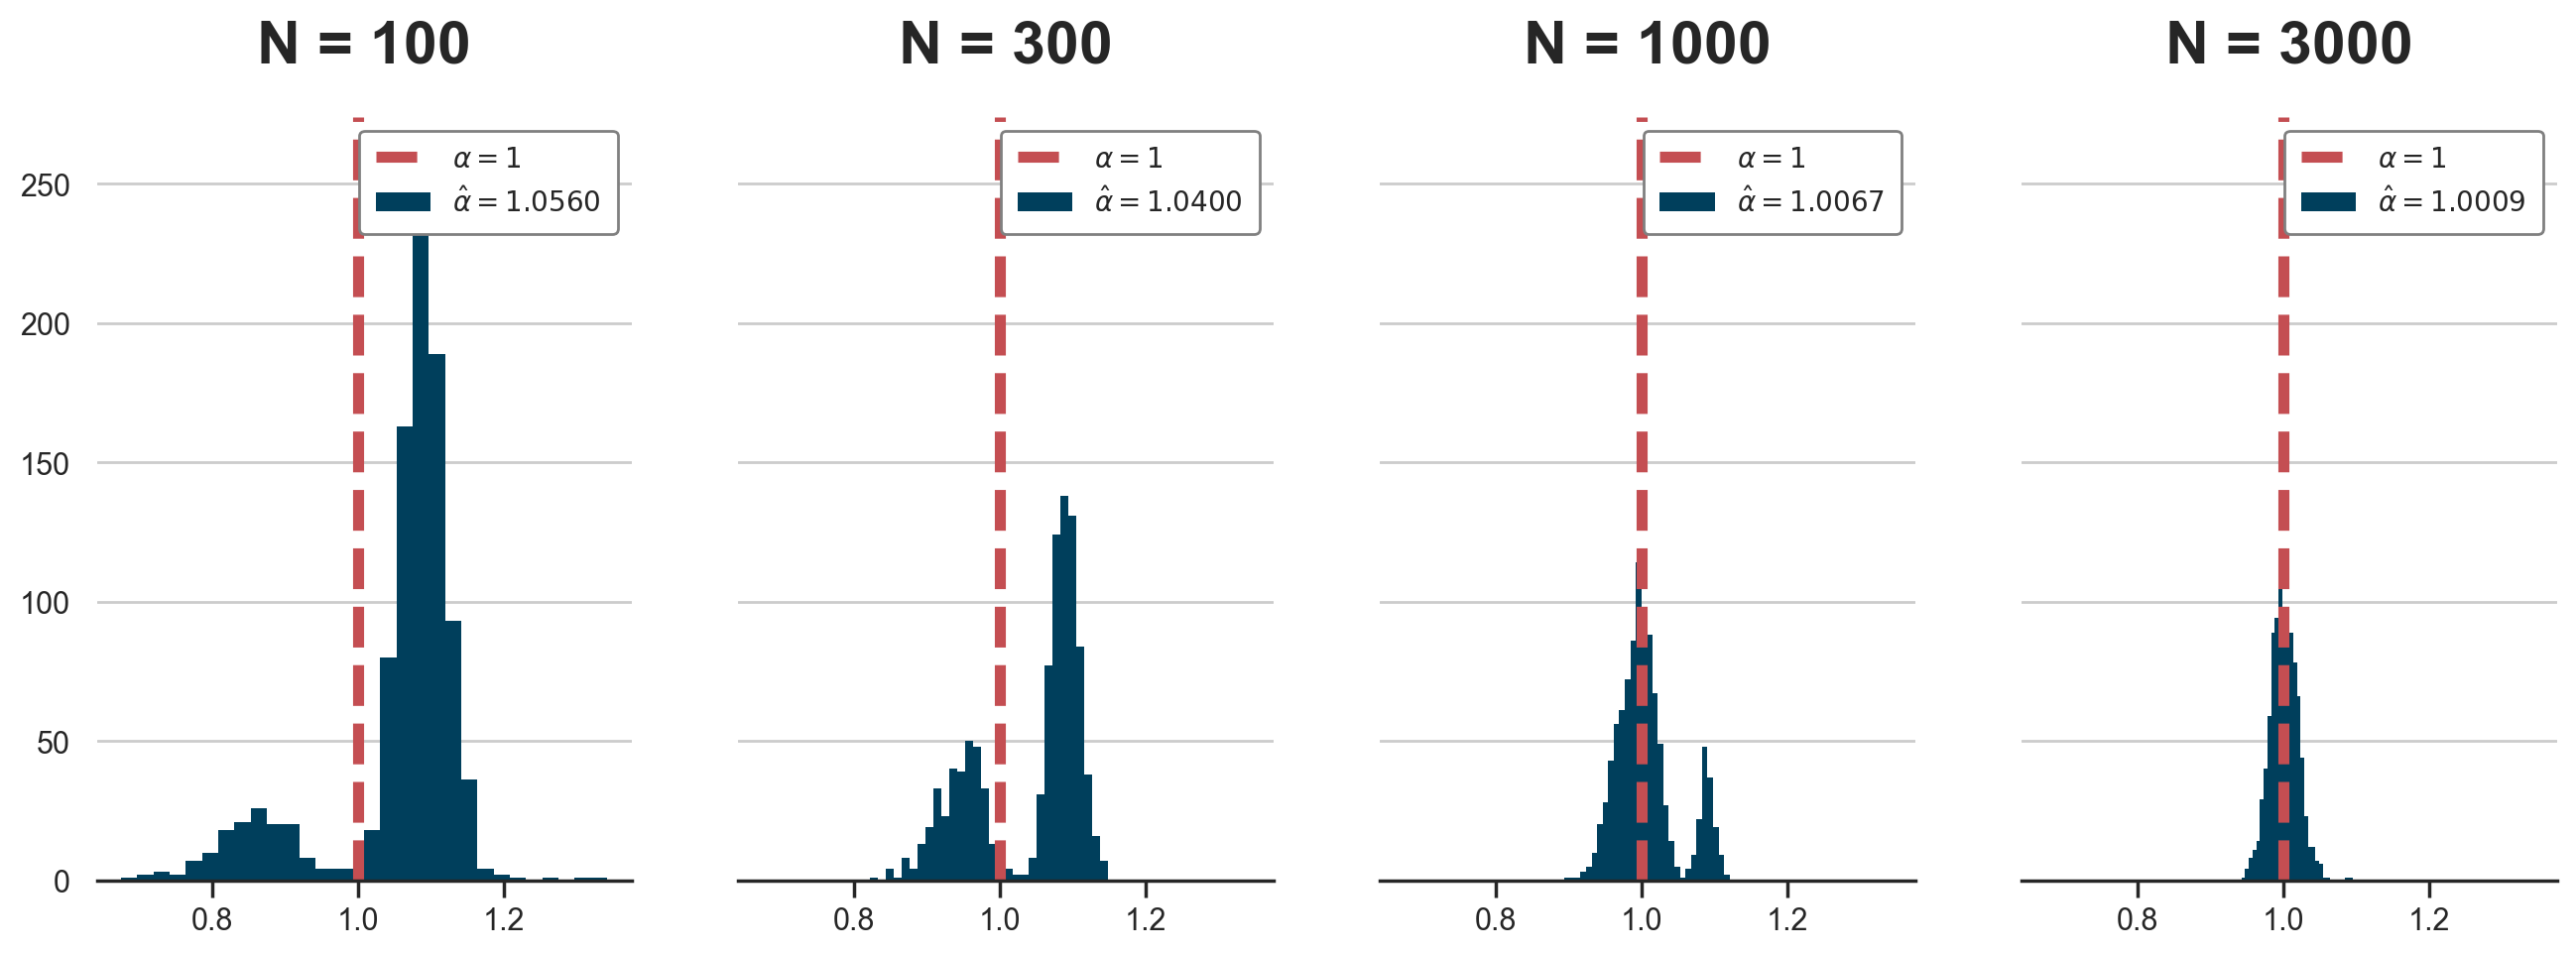

In [18]:
Ns = [100,300,1000,3000]
alphas = {f'N = {n:.0f}':  pre_testing(N=n)['Pre-test'] for n in Ns}
plot_alphas(alphas, true_alpha=1)

Repare que à medida que o tamanho da amostra aumenta (da esquerda para a direita), o viés diminui e a distribuição do estimador
converge para uma distribuição normal.

***A magnitude do beta***

O que aconteceria se o valor de $\beta$ fosse diferente?

* Se $\beta$ é ***muito pequeno***, será difícil detectá-lo e, muitas vezes, acabaremos executando a regressão curta, introduzindo um viés. No entanto, se
é muito pequeno, isso também implica que ***a magnitude do viés*** é pequena e, portanto, não afetará muito nossa estimativa de $\alpha$.
* Se $\beta$ é ***muito grande***, será fácil de detectar e muitas vezes acabaremos executando a regressão longa, evitando o viés (que seria muito grande).

*Simulando sob diferentes valores de $\beta$*

O verdadeiro valor de $\beta$ é 0.3. Vamos simular para 0.03, 0.09, 0.3, e 0.9.

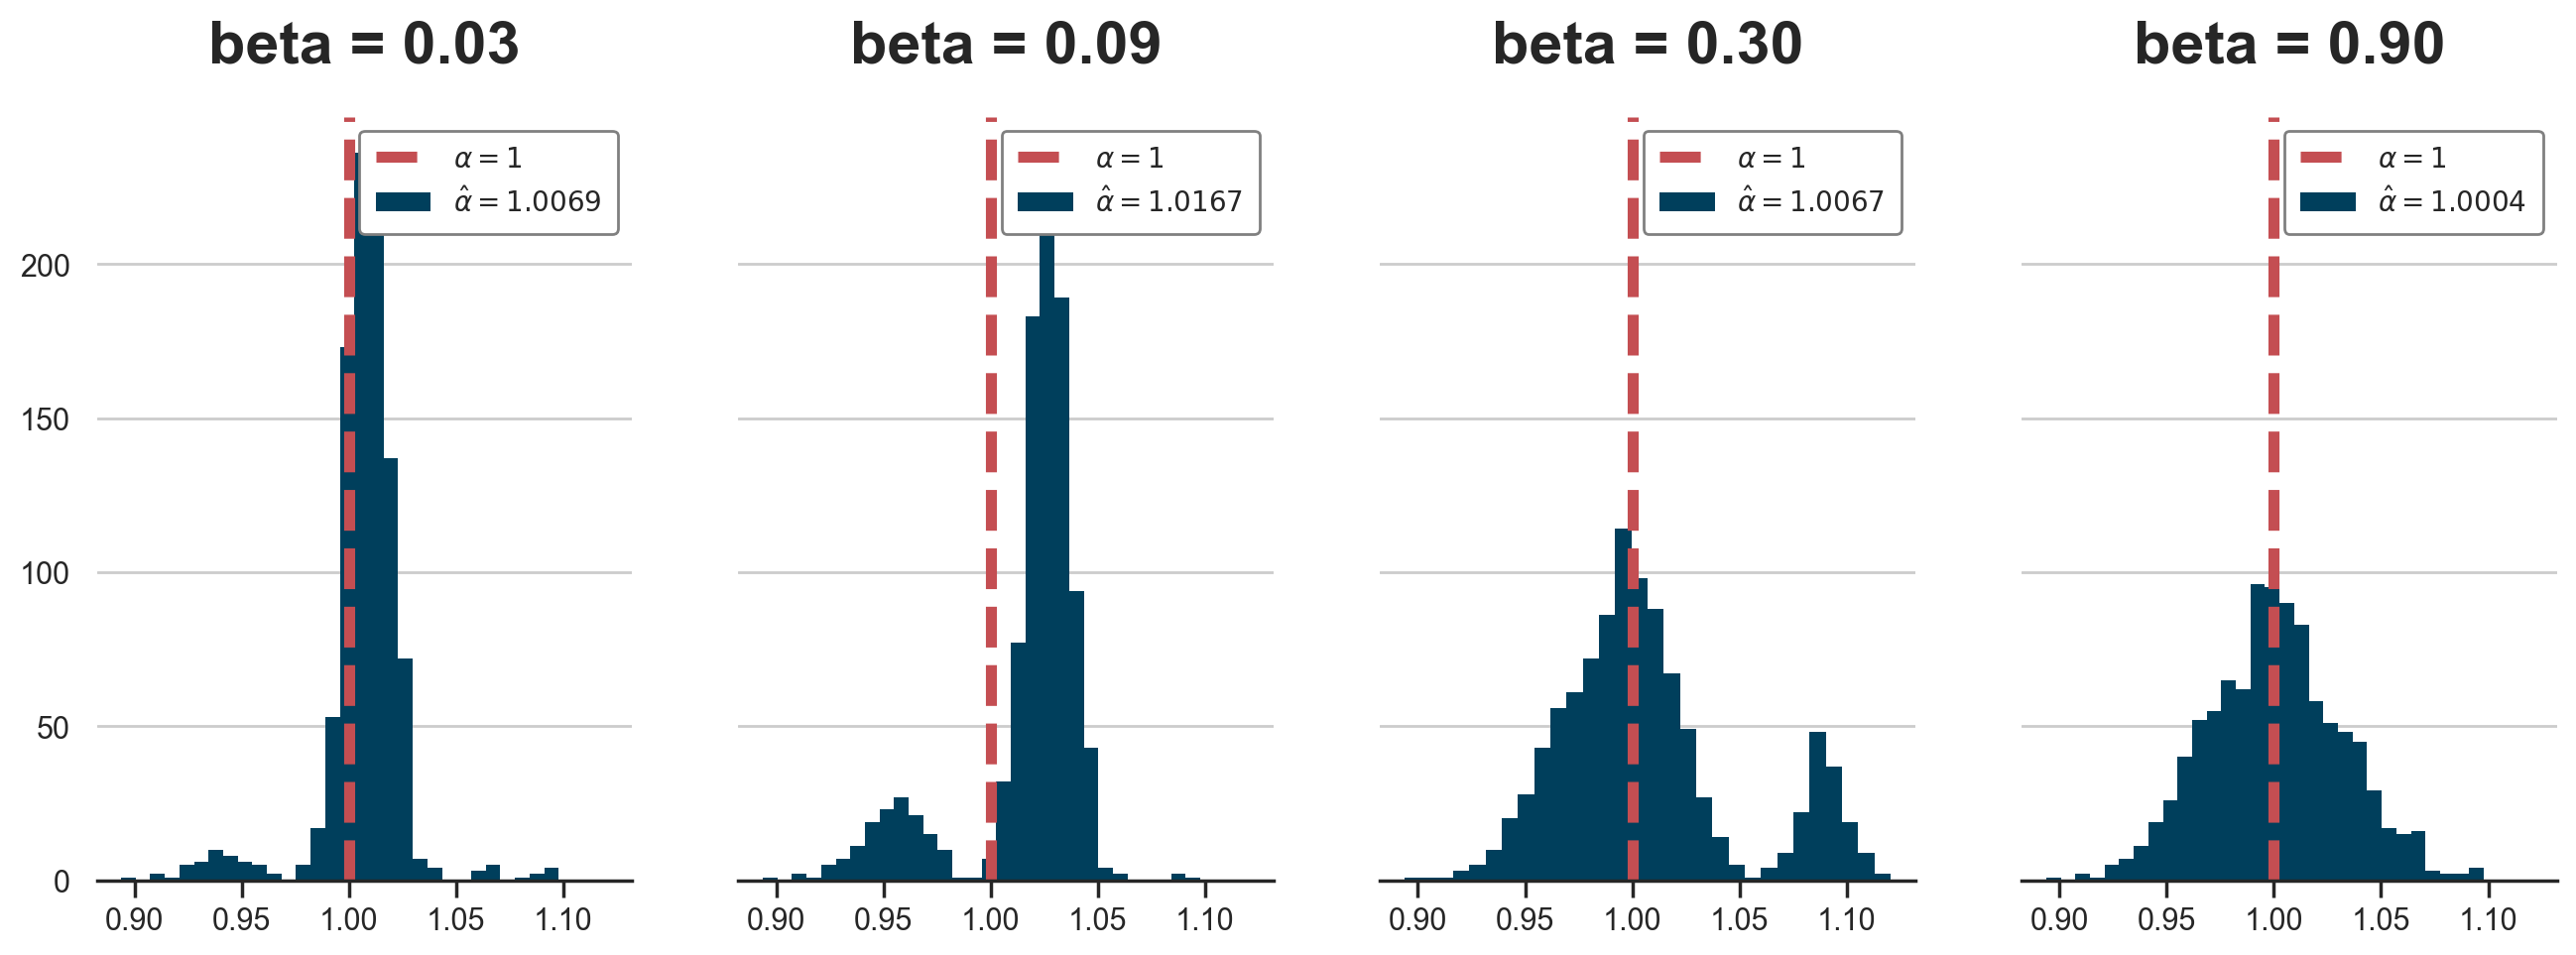

In [19]:
betas = 0.3 * np.array([0.1,0.3,1,3])
alphas = {f'beta = {b:.2f}':  pre_testing(b=b)['Pre-test'] for b in betas}
plot_alphas(alphas, true_alpha=1)

Como podemos ver nos gráficos, à medida que o valor de $\beta$ aumenta, o viés primeiro aparece e depois desaparece. Quando $\beta$ é pequeno (gráfico à esquerda), frequentemente escolhemos a regressão curta, mas o viés é pequeno e a estimativa média é muito próxima do valor real. Para valores intermediários de $\beta$, o viés é sensível e tem um efeito claro na inferência. Por último, em vez disso para grandes valores de $\beta$ (gráfico à direita), sempre executamos a regressão longa e o viés desaparece.

Mas ***quando um coeficiente é grande ou pequeno?***. Ou melhor, é ***grande ou pequeno em relação ao quê?*** 

Em estatística, ***um coeficiente não é avaliado apenas pelo seu valor numérico absoluto, mas sim em relação ao seu erro padrão*** (*Standard Error* - SE). Em outras palavras, ***o que importa é o tamanho do coeficiente comparado à incerteza na sua estimativa***.

Nós costumamos avaliar: 

* $H_{0}:\beta_k = 0$ contra $H_{1}:\beta_k \neq 0$.

​
Utilizamos o teste t de Student para avaliar a significância estatística do coeficiente $\hat{\beta}_k$:

$$ t = \frac{\hat{\beta}_k - \bar{\beta}_k}{\text{SE}(\hat{\beta}_k)} = \frac{\hat{\beta}_k - (0)}{\sqrt{\hat{\sigma}^2 (X'X)^{-1}_{kk}}} $$

ou seja, em termos de estimativa amostral:

$$ t = \frac{\hat{\beta}_k}{\sqrt{\frac{\frac{\sum_{i=1}^{n} \hat{u}_i^2}{n-K}}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}}} $$

Note que o erro padrão da estimativa, $\text{SE}(\hat{\beta}_k)$, depende:

* diretamente da variância residual estimada ($\sum \hat{u}_i^2$), e
* inversamente da variabilidade do regressor $x_k$ (capturada pela soma dos quadrados centrados).

À medida que o tamanho da amostra $n$ aumenta, o erro padrão tende a diminuir. Isso ocorre porque a variância dos estimadores amostrais tende a cair com o aumento da amostra — uma consequência direta do Teorema do Limite Central (TLC).

Formalmente, o TLC afirma que:

$$ \sqrt{n}(\bar{X} - \mu) \xrightarrow{d} N(0, \sigma^2) $$

* Lembre-se: o fator $\sqrt{n}$ é necessário para escalar a média amostral e obter uma distribuição limite não degenerada (normal com variância $\sigma^2$). $Var(\sqrt{n}(\bar{X} - \mu)) = n \cdot Var(\bar{X}) = n \cdot \frac{\sigma^2}{n} = \sigma^2$.

Embora essa fórmula envolva a média amostral $\bar{X}$, o mesmo princípio se aplica a estimadores como $\hat{\beta}_k$, que são combinações lineares de variáveis aleatórias. Assim, temos que:

$$\sqrt{n}(\hat{\beta}_k - \beta_k) \xrightarrow{d} N(0, \Omega) $$

* $\Omega$ é a matriz de variância-covariância assintótica do vetor de estimadores $\hat{\beta}$.
* $\text{Var}(\hat{\beta}_k) = \mathcal{O}\left(\frac{1}{n}\right)$. Ou seja, a variância da estimativa diminui à medida que a amostra cresce, refletindo menor incerteza nas inferências feitas com $\hat{\beta}_k$.

Conclusão: o tamanho de um coeficiente deve ser interpretado relativamente ao seu erro padrão, que por sua vez depende:
* do tamanho da amostra ($n$),
* da variância dos resíduos ($\hat{\sigma}^2$), e
* da variabilidade dos regressores ($x_k$).

Então, estimadores de $\hat{\beta}$ têm distribuição assintoticamente normal, com ***variância decrescendo*** na ordem de $\frac{1}{n}$ e, respectivamente, ***erro padrão decrescendo*** com $\frac{1}{\sqrt{n}}$. Portanto, a interpretação do tamanho de um coeficiente deve sempre levar em conta esse escalonamento: à medida que a amostra cresce, mesmo coeficientes menores podem se tornar estatisticamente significantes, pois a incerteza diminui.

A ideia é mais fácil de mostrar do que de explicar. Por isso, vamos repetir a simulação anterior, mas agora aumentando o coeficiente $\beta$ proporcionalmente ao inverso da raiz do tamanho da amostra:

$$ \beta = \frac{(0.3).30}{\sqrt{n}} $$

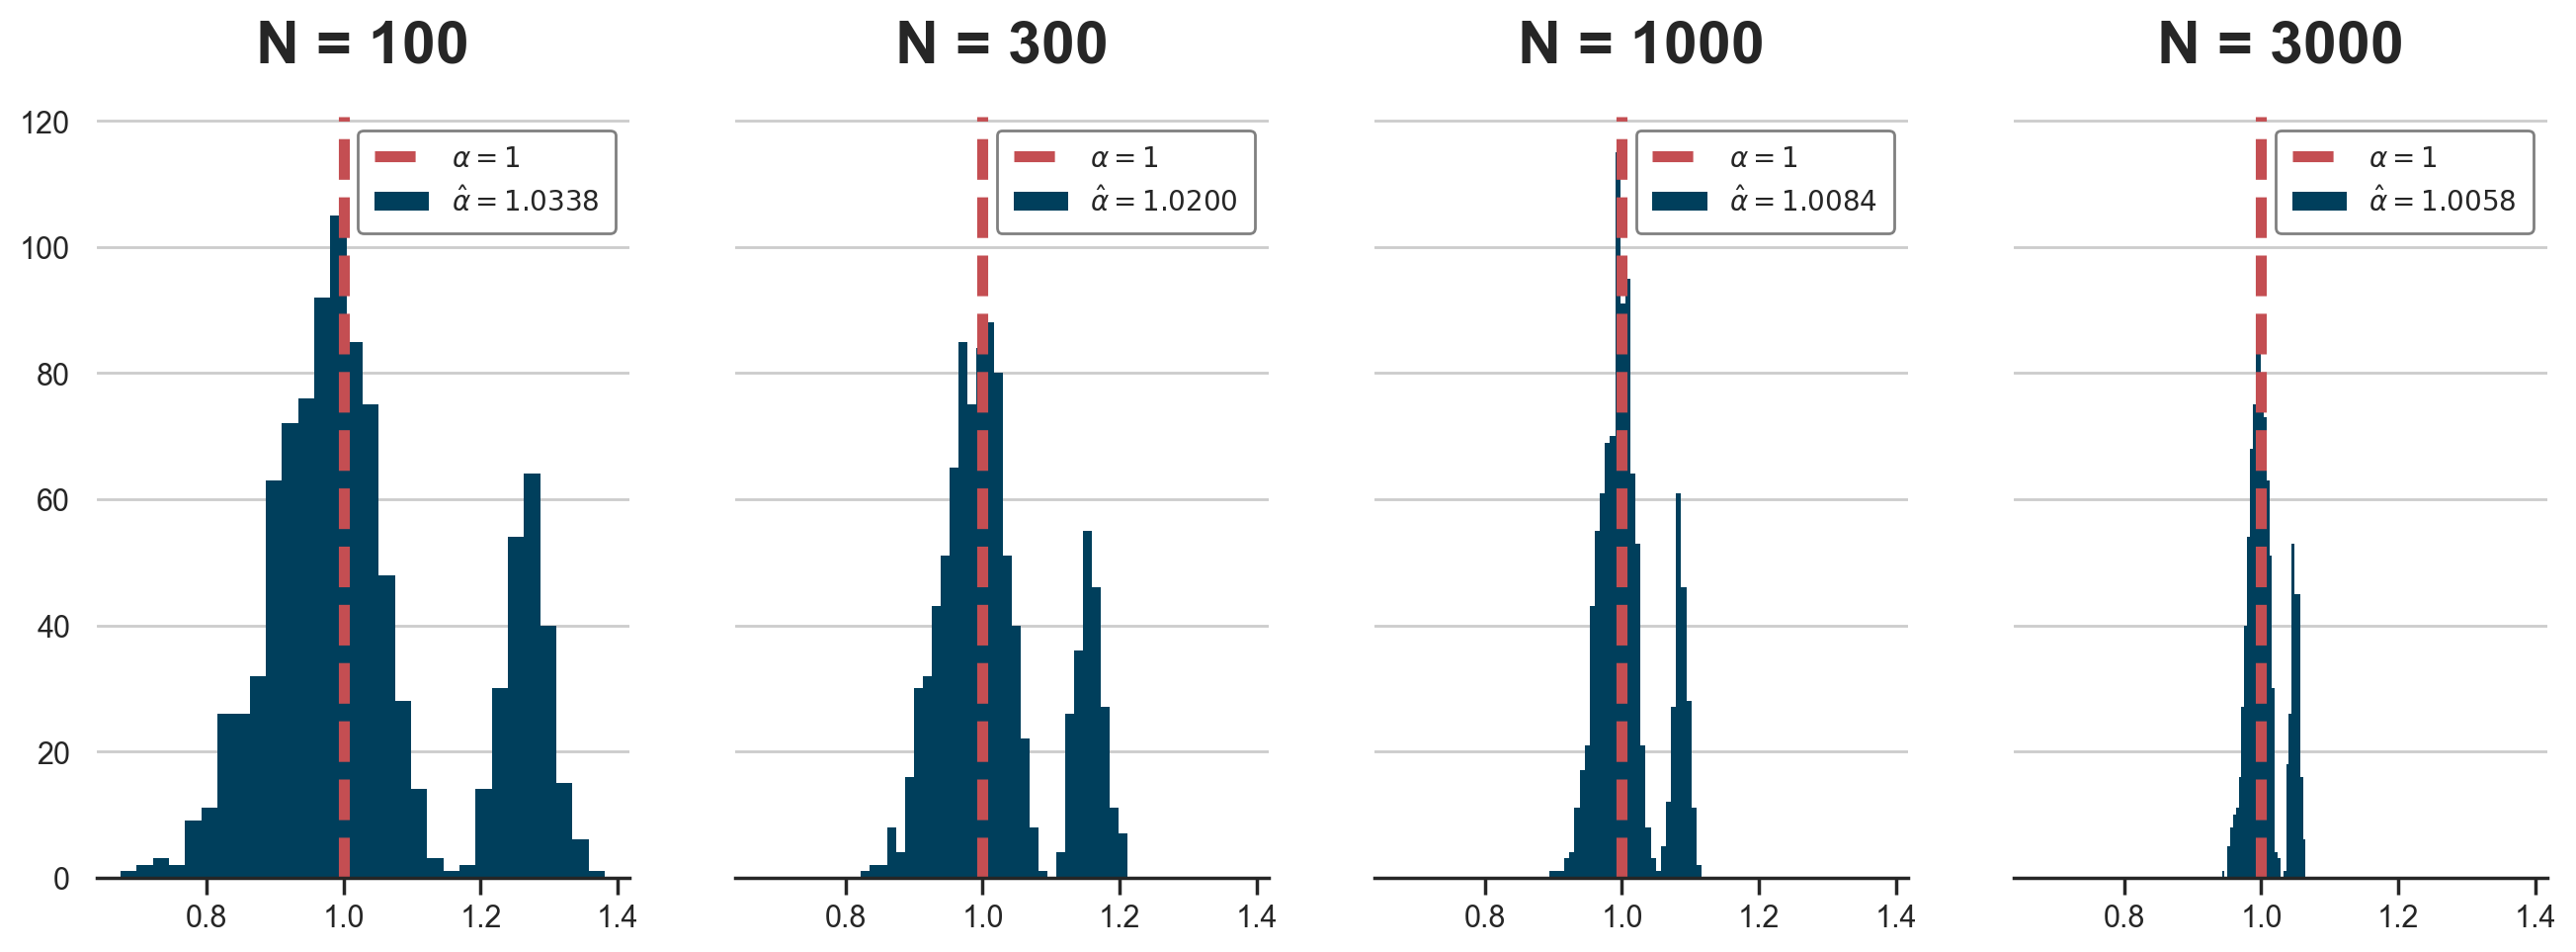

In [20]:
betas = 0.3 * 30 / np.sqrt(Ns)
alphas = {f'N = {n:.0f}':  pre_testing(b=b, N=n)['Pre-test'] for n,b in zip(Ns,betas)}
plot_alphas(alphas, true_alpha=1)

Como podemos ver, agora que $\beta$ é proporcional a  $\frac{1}{\sqrt{n}}$, a distorção não desaparece, independentemente do tamanho da amostra. Portanto, a inferência sempre estará errada.

Embora um coeficiente que depende do tamanho da amostra possa ***não parecer intuitivo***, ele captura bem a ideia de ***sensibilidade*** em um contexto onde fazemos inferências com base em resultados assintóticos, principalmente o Teorema do Limite Central. De fato, o Teorema do Limite Central se baseia em um tamanho de amostra infinitamente grande. *No entanto, com uma quantidade infinita de dados, nenhum coeficiente é pequeno e qualquer efeito diferente de zero é detectado com certeza*.

### Post-Double Selection

A solução para o problema do pre-test é conhecida como ***Post-Double Selection***, ou ***Seleção Pós-Dupla***. O método foi introduzido pela primeira vez em ***Belloni, Chernozhukov, Hansen (2014)*** e posteriormente expandido em outros artigos. O nome *Seleção pós-dupla* vem do fato de que agora não estamos realizando a seleção de variáveis ​​uma, mas duas vezes.

Os autores assumem o seguinte processo gerador dose dados:

$$ Y = \alpha D + \beta X + \epsilon $$

$$ D = \delta X + \eta $$

Seguindo nosso exemplo, $Y$ é o resultado (vendas), $D$ é a variável de tratamento (gastos com publicidade), $X$ são as variáveis de controle (Gestão da empresa), geralmente estamos interessados em casos onde $X$ é de alta dimensão, ou seja, com mais variáveis do que observações. Logo, a seleção de variáveis é essencial para a análise.

O procedimento de *Post-Double Selection* é o seguinte:
1. **Reduced Form Selection** (Seleção da forma reduzida): Lasso de $Y$ sobre $X$, e seleciona as  variáveis de controle estatísticamente significativas em um conjunto $S_{RF}$.
2. **First Stage Selection** (Seleção da primeira etapa): regressão $D$ sobre $X$. Seleciona as variáveis significativas em um conjunto $S_{FS}$.
3. Regressão de $Y$ sobre $D$ e a união das variáveis selecionadas nos dois primeiros passos: $S = S_{RF} \cup S_{FS}$.


Os autores mostram que este procedimento produz intervalos de confiança para o coeficiente de interesse $\alpha$ que tenham a cobertura correta, ou seja, a probabilidade correta de erro tipo 1.

Este procedimento é sempre menos parcimonioso, em termos de seleção de variáveis, do que o pré-teste. De fato, ainda selecionamos todas as variáveis ​​que teríamos selecionado no pré-teste, mas, na primeira etapa, podemos selecionar variáveis ​​adicionais


***Intuição***

A ideia por trás da pós-seleção dupla é: limitar o viés das variáveis ​​omitidas.

$$ OVB = \beta \delta $$

onde 

$$ \beta = \frac{\text{Cov}(X, Y)}{\text{Var}(X)} $$

e

$$ \delta = \frac{\text{Cov}(X, D)}{\text{Var}(X)} $$


Como podemos ver, o viés da variável omitida vem do produto de duas grandezas relacionadas à variável omitida $X$:
* correlação parcial com o resultado $Y$; ($\beta$)
* correlação parcial com a variável de interesse/tratamento $D$; ($\delta$)


***consistência***

No pre-test selecionamos variáveis que são significativas em uma regressão auxiliar de $Y$ sobre $X$, e incluímos no modelo. Nesse processo:
* Se omitirmos uma variável $X_j$ que tem $\beta_j$ pequeno, o viés da variável omitida é pequeno.
* Como o critério de seleção via Lasso garante que $|\beta_j| \leq \frac{c}{\sqrt{n}}$ (para variáveis omitidas), o viés total do estimador tende a zero conforme $n \to \infty$.

Logo, o estimador é consistente: converge para o verdadeiro valor de $\alpha$ à medida que $n$ cresce.

***Validade dos intervalos de confiança***

Mas para fazer inferência (construir ICs), isso não basta. Aqui entra o ponto crucial:
* O desvio padrão assintótico do estimador típico (como OLS) é da ordem de $\frac{1}{\sqrt{n}}$, por causa do Teorema do Limite Central (TLC).
* Se o viés também for da ordem $\frac{1}{\sqrt{n}}$, ele não desaparece em relação ao erro padrão → então ele contamina os intervalos de confiança, deslocando-os sistematicamente.

Logo, precisamos que o viés convirja para zero mais rápido que $\frac{1}{\sqrt{n}}$. Porque ele força os dois componentes do viés da variável omitida — $\beta_j$ e $\delta_j$ — a serem ambos da ordem no máximo $\frac{c}{\sqrt{n}}$.

$$|\text{OVB}_j| = |\beta_j \delta_j| \leq \frac{c^2}{n}$$

O viés total (mesmo com múltiplas variáveis omitidas) fica da ordem $\frac{1}{n}$, o que é muito menor que $\frac{1}{\sqrt{n}}$ — e aí o TLC funciona bem e o IC tem cobertura correta.

No nosso contexto, o viés da variável omitida é $\beta \delta $ queremos que ele convirja para zero mais rápido do que $\frac{1}{\sqrt{n}}. 
 
* Seleção de forma reduzida (pré-teste): qualquer variável “ausente” $j$ tem $| \beta_{j}| \leq \frac{c}{\sqrt{n}} $
* Seleção do primeiro estágio (adicional): qualquer variável “ausente” $j$ e tem $|\delta_{i} | \leq \frac{c}{\sqrt{n}}$
  
Como consequência, enquanto o número de variáveis omitidas for finito, o viés da variável omitida irá convergir para zero a uma taxa $\frac{1}{n}$, que é mais rápido que $\frac{1}{\sqrt{n}}$. 

***Aplicação***

Vamos agora voltar ao nosso exemplo e testar o procedimento de seleção pós-dupla. Na prática, queremos fazer o seguinte:

* Seleção do primeiro estágio $ads$ : regredir em *Manag*. Verifique se *Manag* é estatisticamente significativo
* Seleção de forma reduzida *sales* : regredir em *Manag*. Verifique se *Manag* é estatisticamente significativo
* Regredir *sales* e *ads* incluir *Manag* somente se foi significativo em qualquer uma das duas regressões anteriores
* Atualizo a função *pre_test* da primeira parte do post para calcular também o estimador de pós-seleção dupla.



In [28]:
def pre_test(d='ads', y='sales', x='Manag', K=1000, **kwargs):
    
    # Init
    alphas = pd.DataFrame({'Long': np.zeros(K), 
             'Short': np.zeros(K), 
             'Pre-test': np.zeros(K),
             'Post-double': np.zeros(K)})

    # Loop over simulations
    for k in range(K):
        
        # Generate data
        df = dgp_pretest().generate_data(seed=k, **kwargs)
        
        # Compute coefficients
        alphas['Long'][k] = smf.ols(f'{y} ~ {d} + {x}', df).fit().params[1]
        alphas['Short'][k] = smf.ols(f'{y} ~ {d}', df).fit().params[1]
    
        # Compute significance of beta and gamma
        p_value_ydx = smf.ols(f'{y} ~ {d} + {x}', df).fit().pvalues[2]
        p_value_yx = smf.ols(f'{y} ~ {x}', df).fit().pvalues[1]
        p_value_dx = smf.ols(f'{d} ~ {x}', df).fit().pvalues[1]
        
        # Select pre-test specification based on regression of y on d and x
        if p_value_ydx<0.05:
            alphas['Pre-test'][k] = alphas['Long'][k]
        else:
            alphas['Pre-test'][k] = alphas['Short'][k]
            
        # Select post-double specification based on regression of y on d and x
        if p_value_yx<0.05 or p_value_dx<0.05:
            alphas['Post-double'][k] = alphas['Long'][k]
        else:
            alphas['Post-double'][k] = alphas['Short'][k]
    
    return alphas

alphas = pre_test()

Agora podemos traçar as distribuições (por meio de simulações) dos coeficientes estimados.

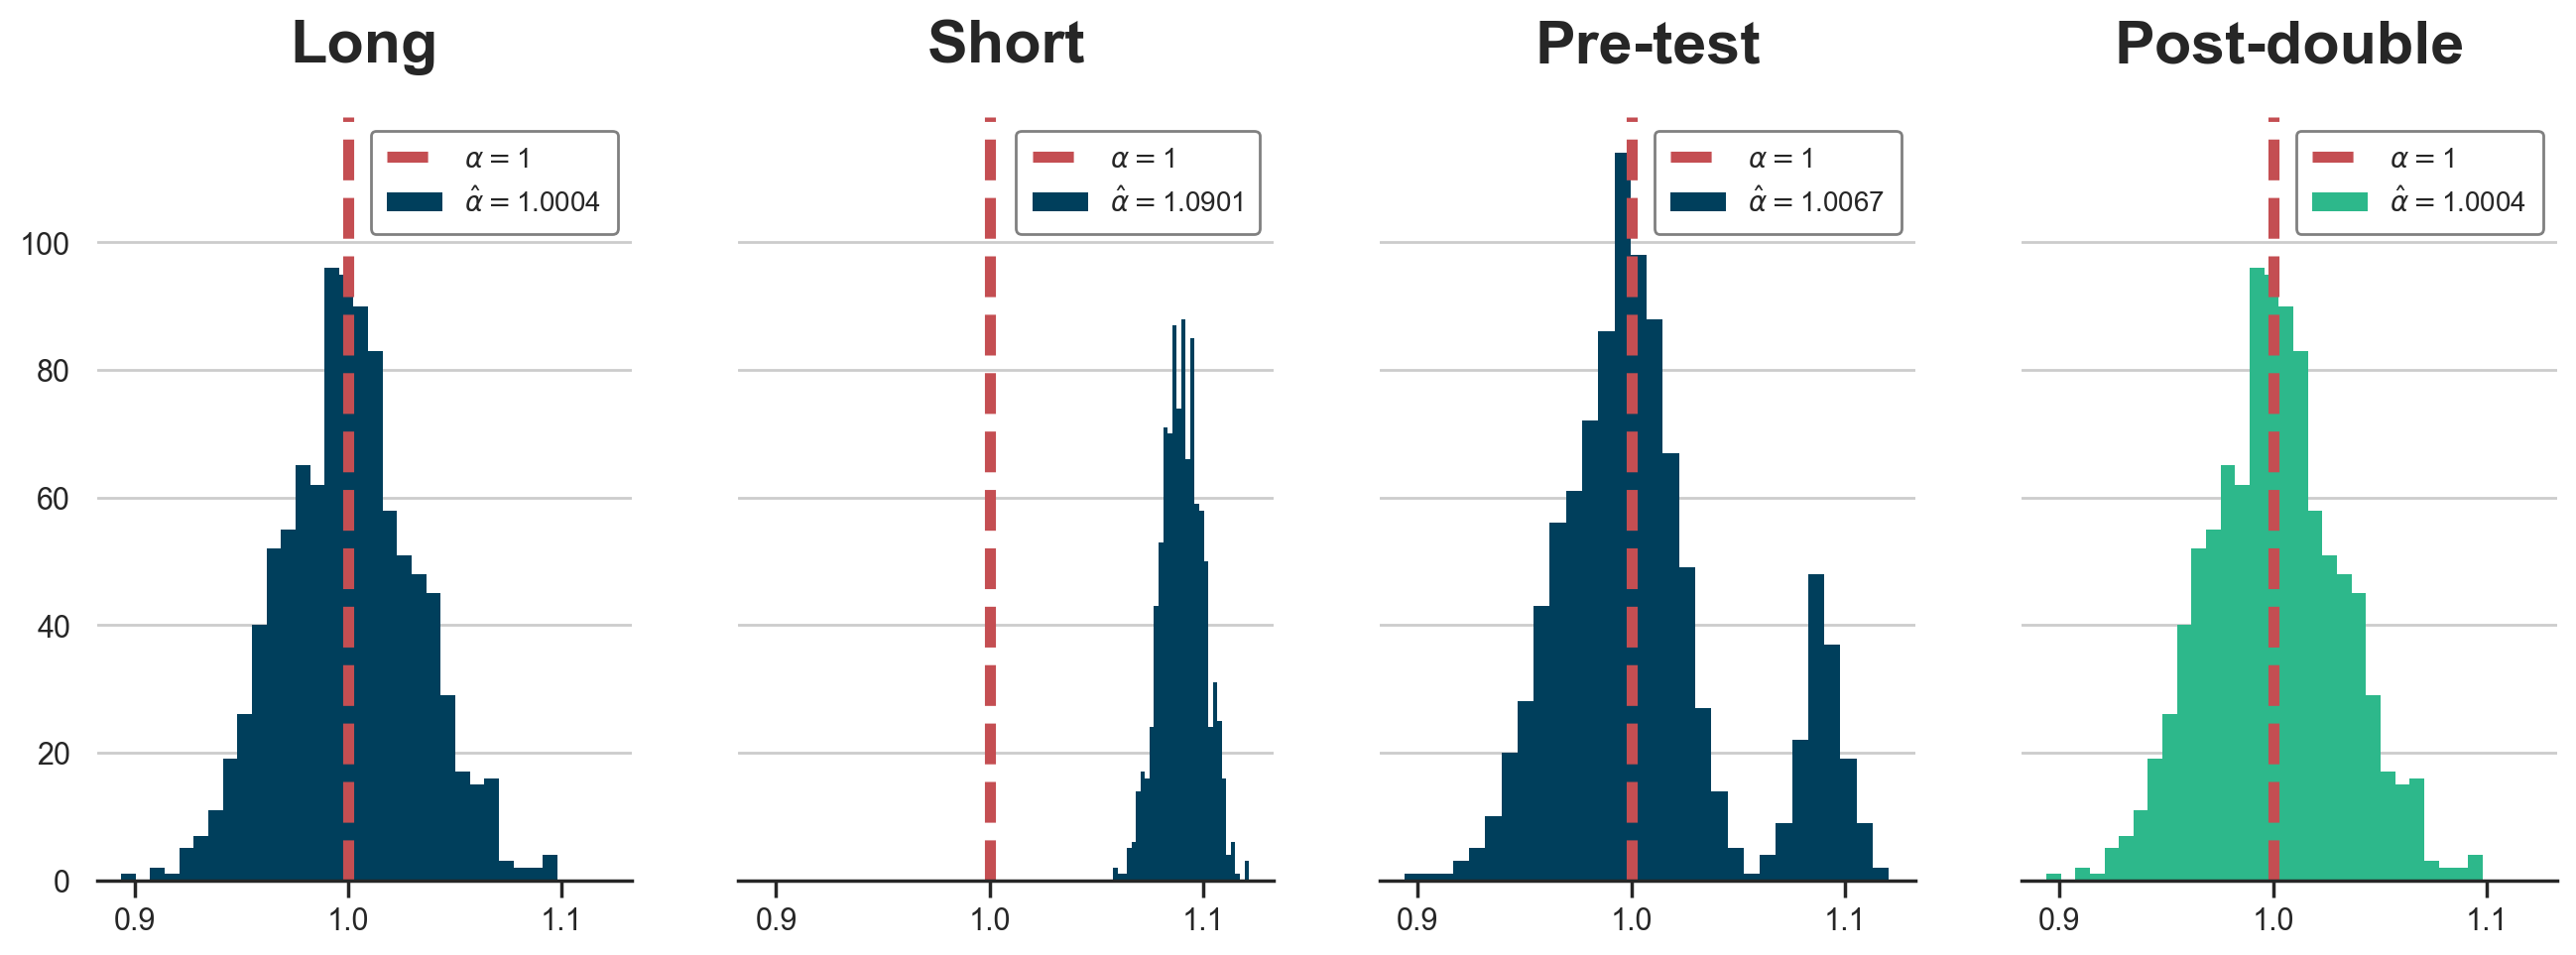

In [29]:
def plot_alphas(alphas, true_alpha):
    
    # Init plot
    K = len(alphas.columns)
    fig, axes = plt.subplots(1, K, figsize=(4*K, 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.columns):
        axes[i].hist(alphas[key].values, bins=30, lw=.1, color=f'C{int(i==3)*2}')
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        legend_text = [rf'$\alpha=${true_alpha}', rf'$\hat \alpha=${np.mean(alphas[key]):.4f}']
        axes[i].legend(legend_text, prop={'size': 10}, loc='upper right')

plot_alphas(alphas, true_alpha=1)

Como podemos ver, o estimador de seleção pós-dupla sempre seleciona corretamente a regressão longa e, portanto, tem a distribuição correta.

***Robustez do procedimento da seleção pós-dupla***

Anteriormente, realizamos algumas simulações para investigar quando surge o viés do pré-teste. Vimos que o pré-teste é um problema para

* Diferentes tamanhos de amostra (Tamanhos de amostra pequenos $n$).
* Diferentes valores de $\beta$.
* Valor de $\beta$ varia conforme o tamanho da amostra.

Vamos verificar se a seleção pós-dupla remove o viés de regularização em ***todos*** os casos anteriores.


***Diferentes tamanhos de amostra***

Primeiro, vamos simular a distribuição do estimador pós-seleção dupla $\alpha_{postdupla}$ para diferentes tamanhos de amostra.

In [30]:
Ns = [100,300,1000,3000]
alphas = {f'N = {n:.0f}':  pre_test(N=n) for n in Ns}

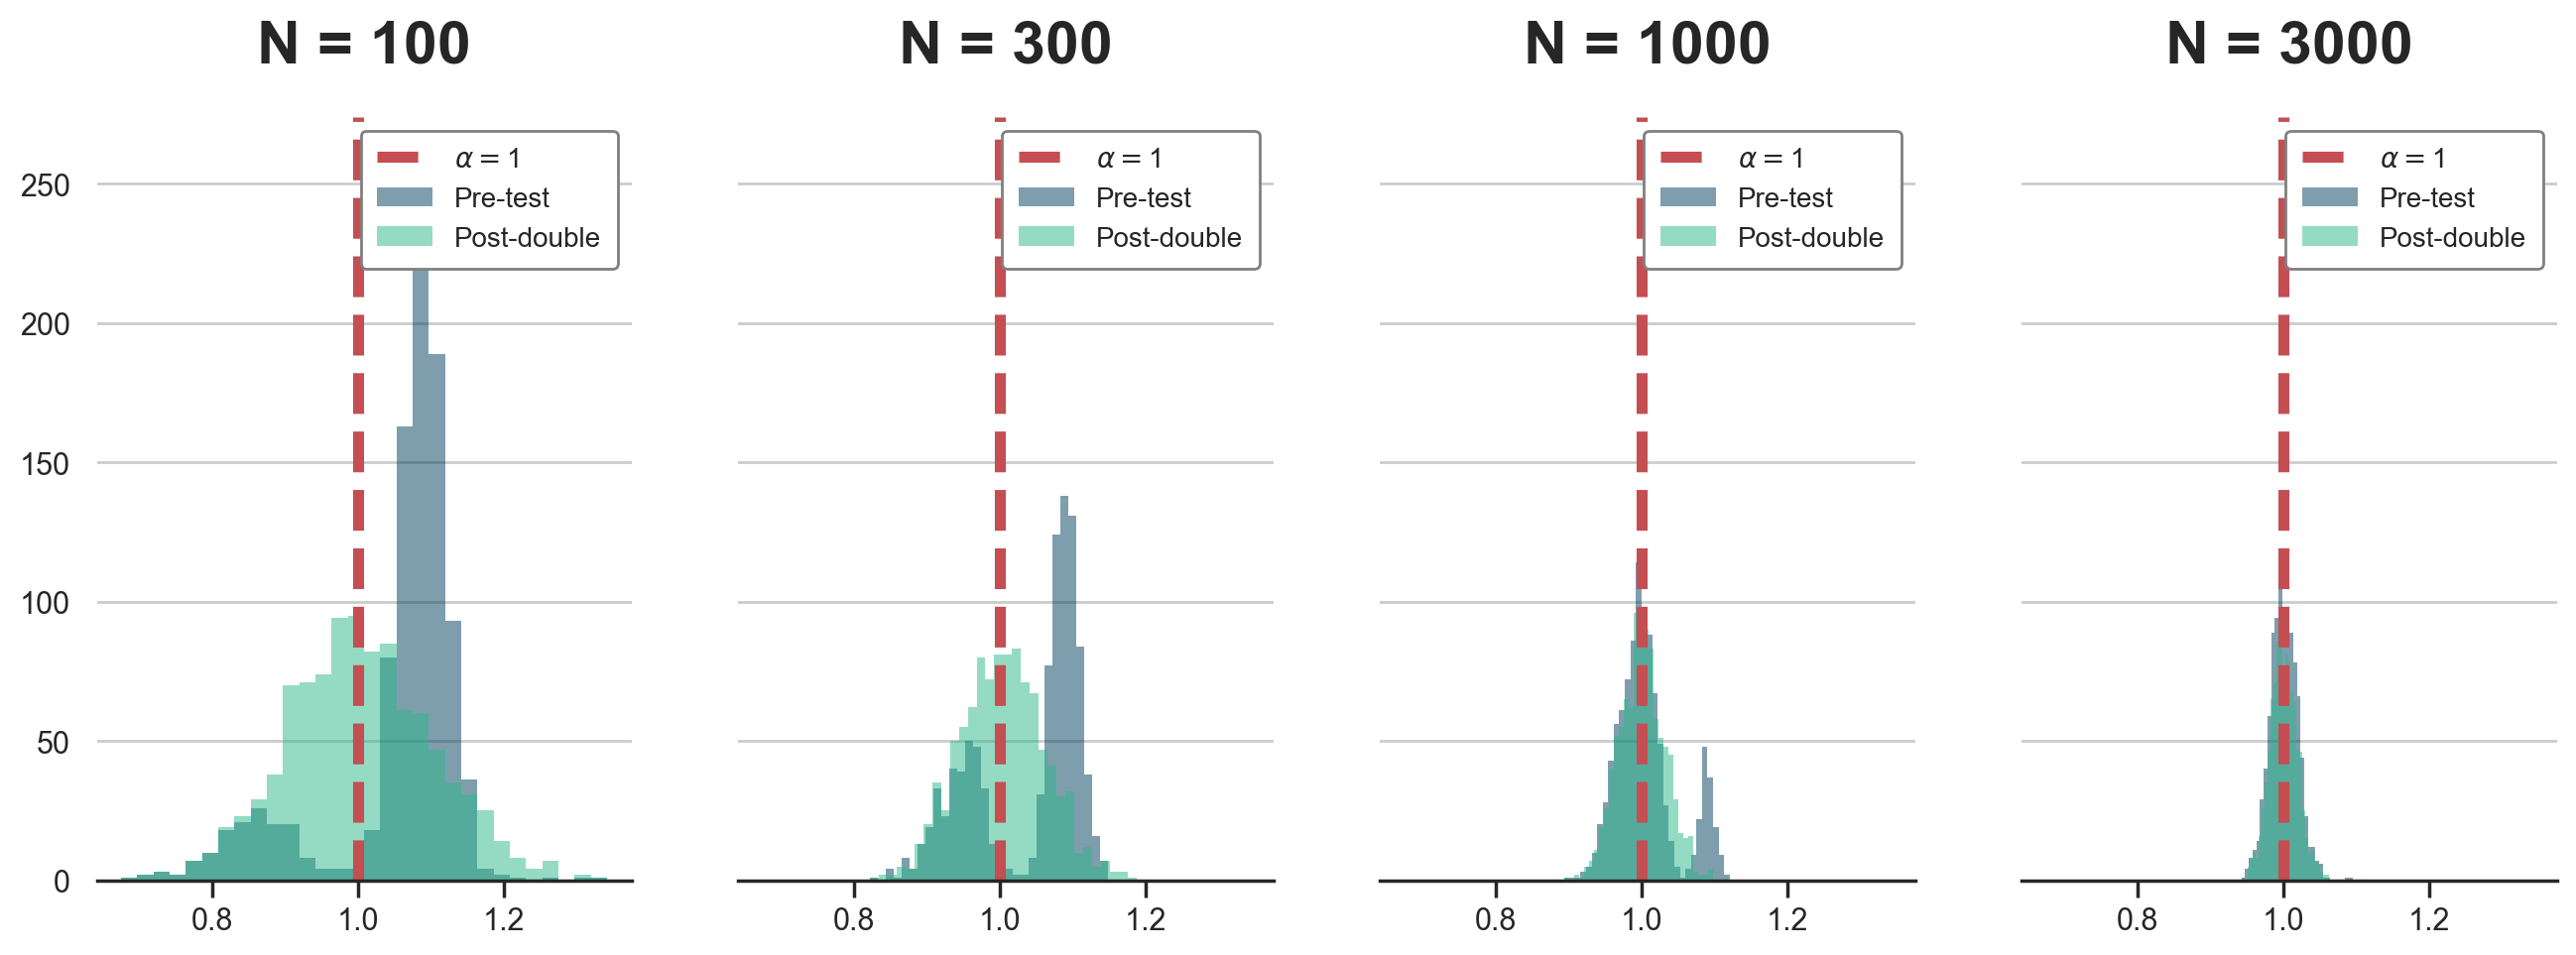

In [31]:
def compare_alphas(alphas, true_alpha):
    
    # Init plot
    fig, axes = plt.subplots(1, len(alphas), figsize=(4*len(alphas), 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.keys()):
        axes[i].hist(alphas[key]['Pre-test'], bins=30, lw=.1, alpha=0.5)
        axes[i].hist(alphas[key]['Post-double'], bins=30, lw=.1, alpha=0.5, color='C2')
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        axes[i].legend([rf'$\alpha=${true_alpha}', 'Pre-test', 'Post-double'], 
                       prop={'size': 10}, loc='upper right')

compare_alphas(alphas, true_alpha=1)

Para amostras pequenas, a distribuição do estimador pré-teste não é normal, mas sim bimodal. A partir dos gráficos, podemos observar que o estimador pós-duplo é gaussiano também em amostras pequenas.

***Diferentes valores de $\beta$***

Agora repetimos o mesmo exercício, mas para valores diferentes de $\beta$, o coeficiente de *past_sales* em *sales*.

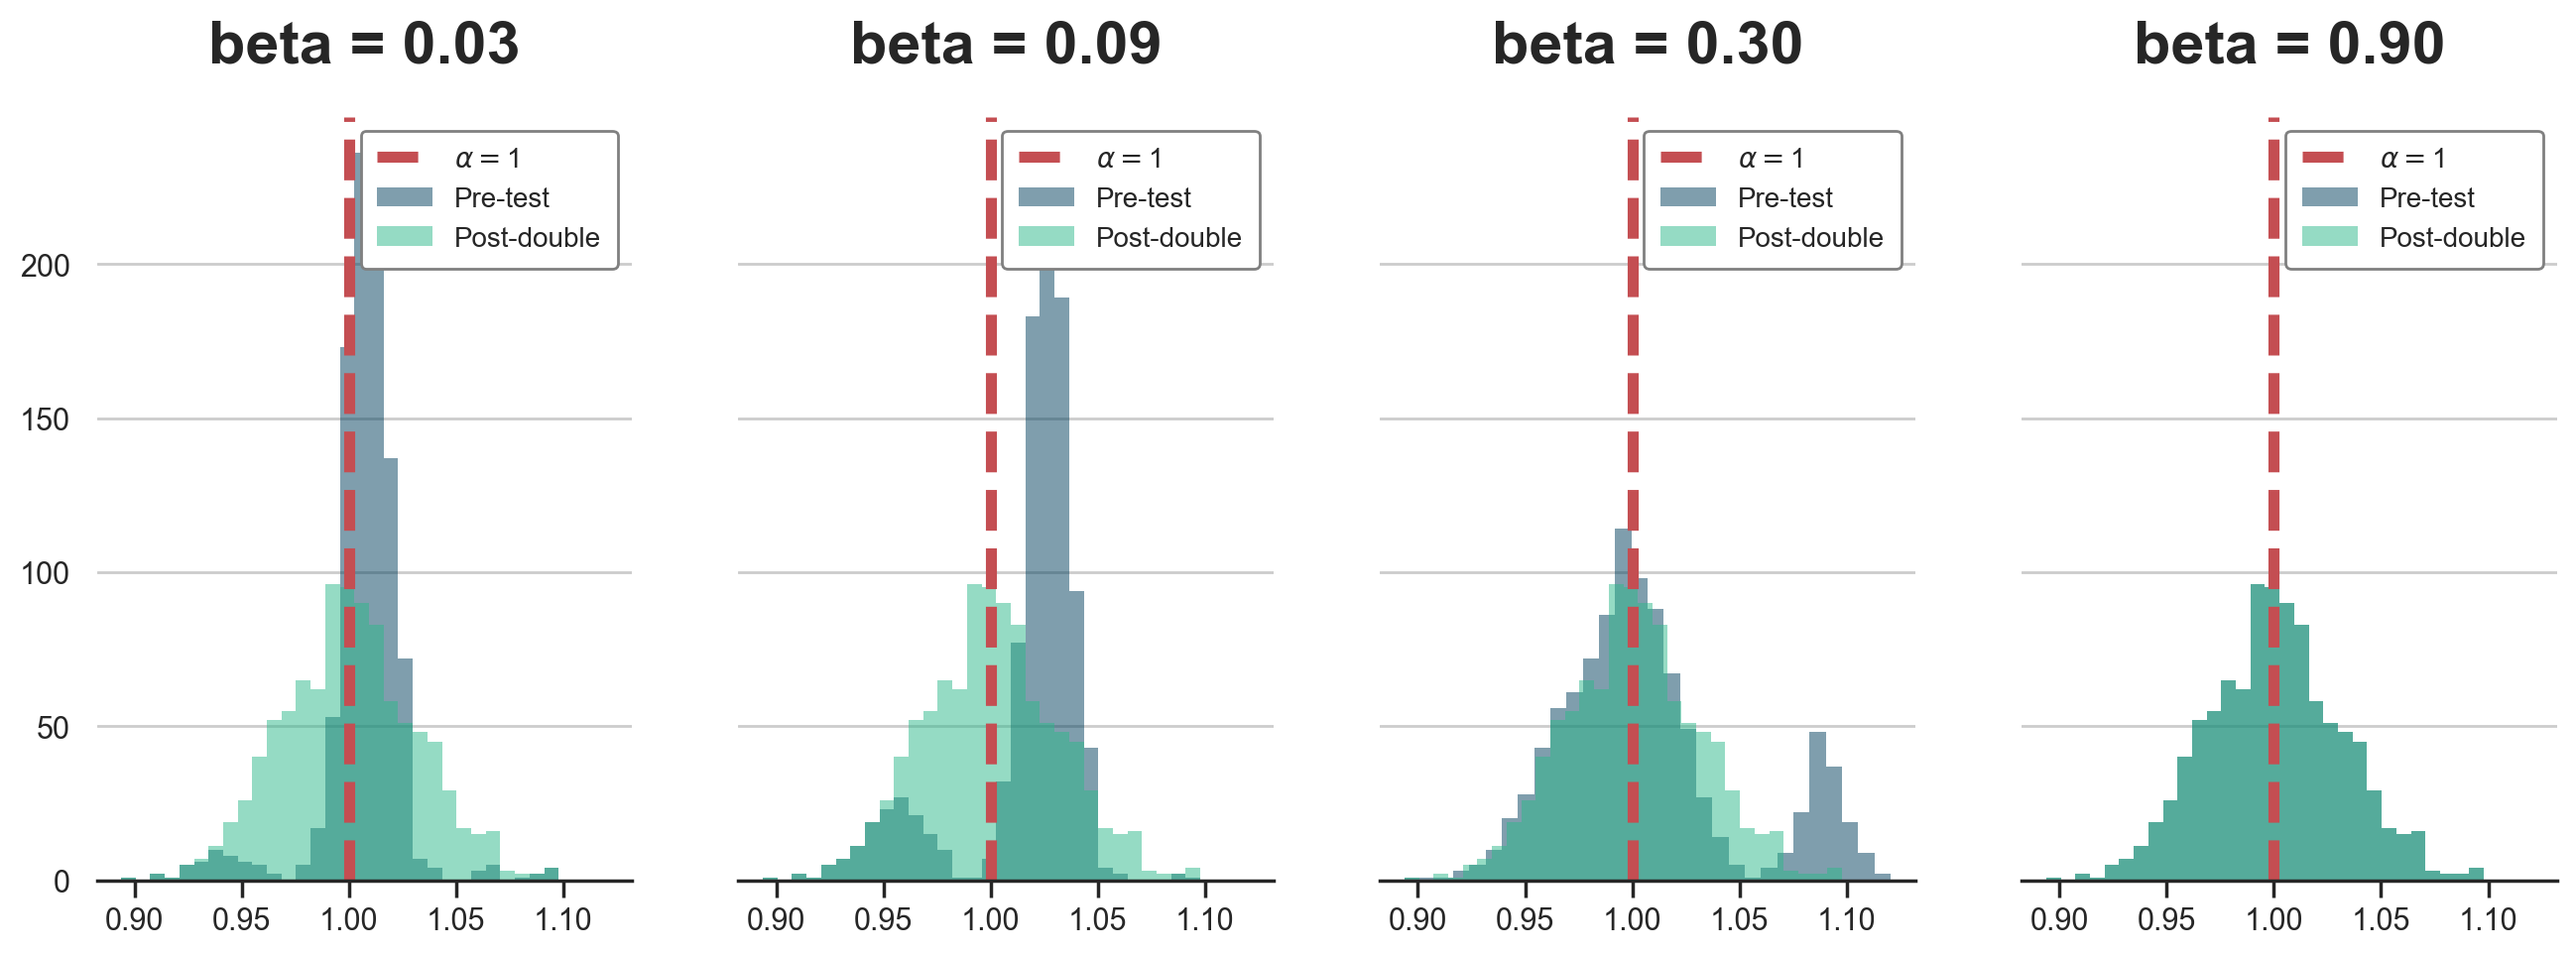

In [32]:
betas = 0.3 * np.array([0.1,0.3,1,3])
alphas = {f'beta = {b:.2f}': pre_test(b=b) for b in betas}
compare_alphas(alphas, true_alpha=1)

Novamente, o estimador de seleção pós-dupla tem uma distribuição gaussiana independentemente do valor de $\beta$, enquanto o estimador de pré-teste sofre de viés de regularização.

***Valor de $\beta$ varia conforme o tamanho da amostra***

Para a última simulação, alteramos o coeficiente em função do tamanho da amostra.

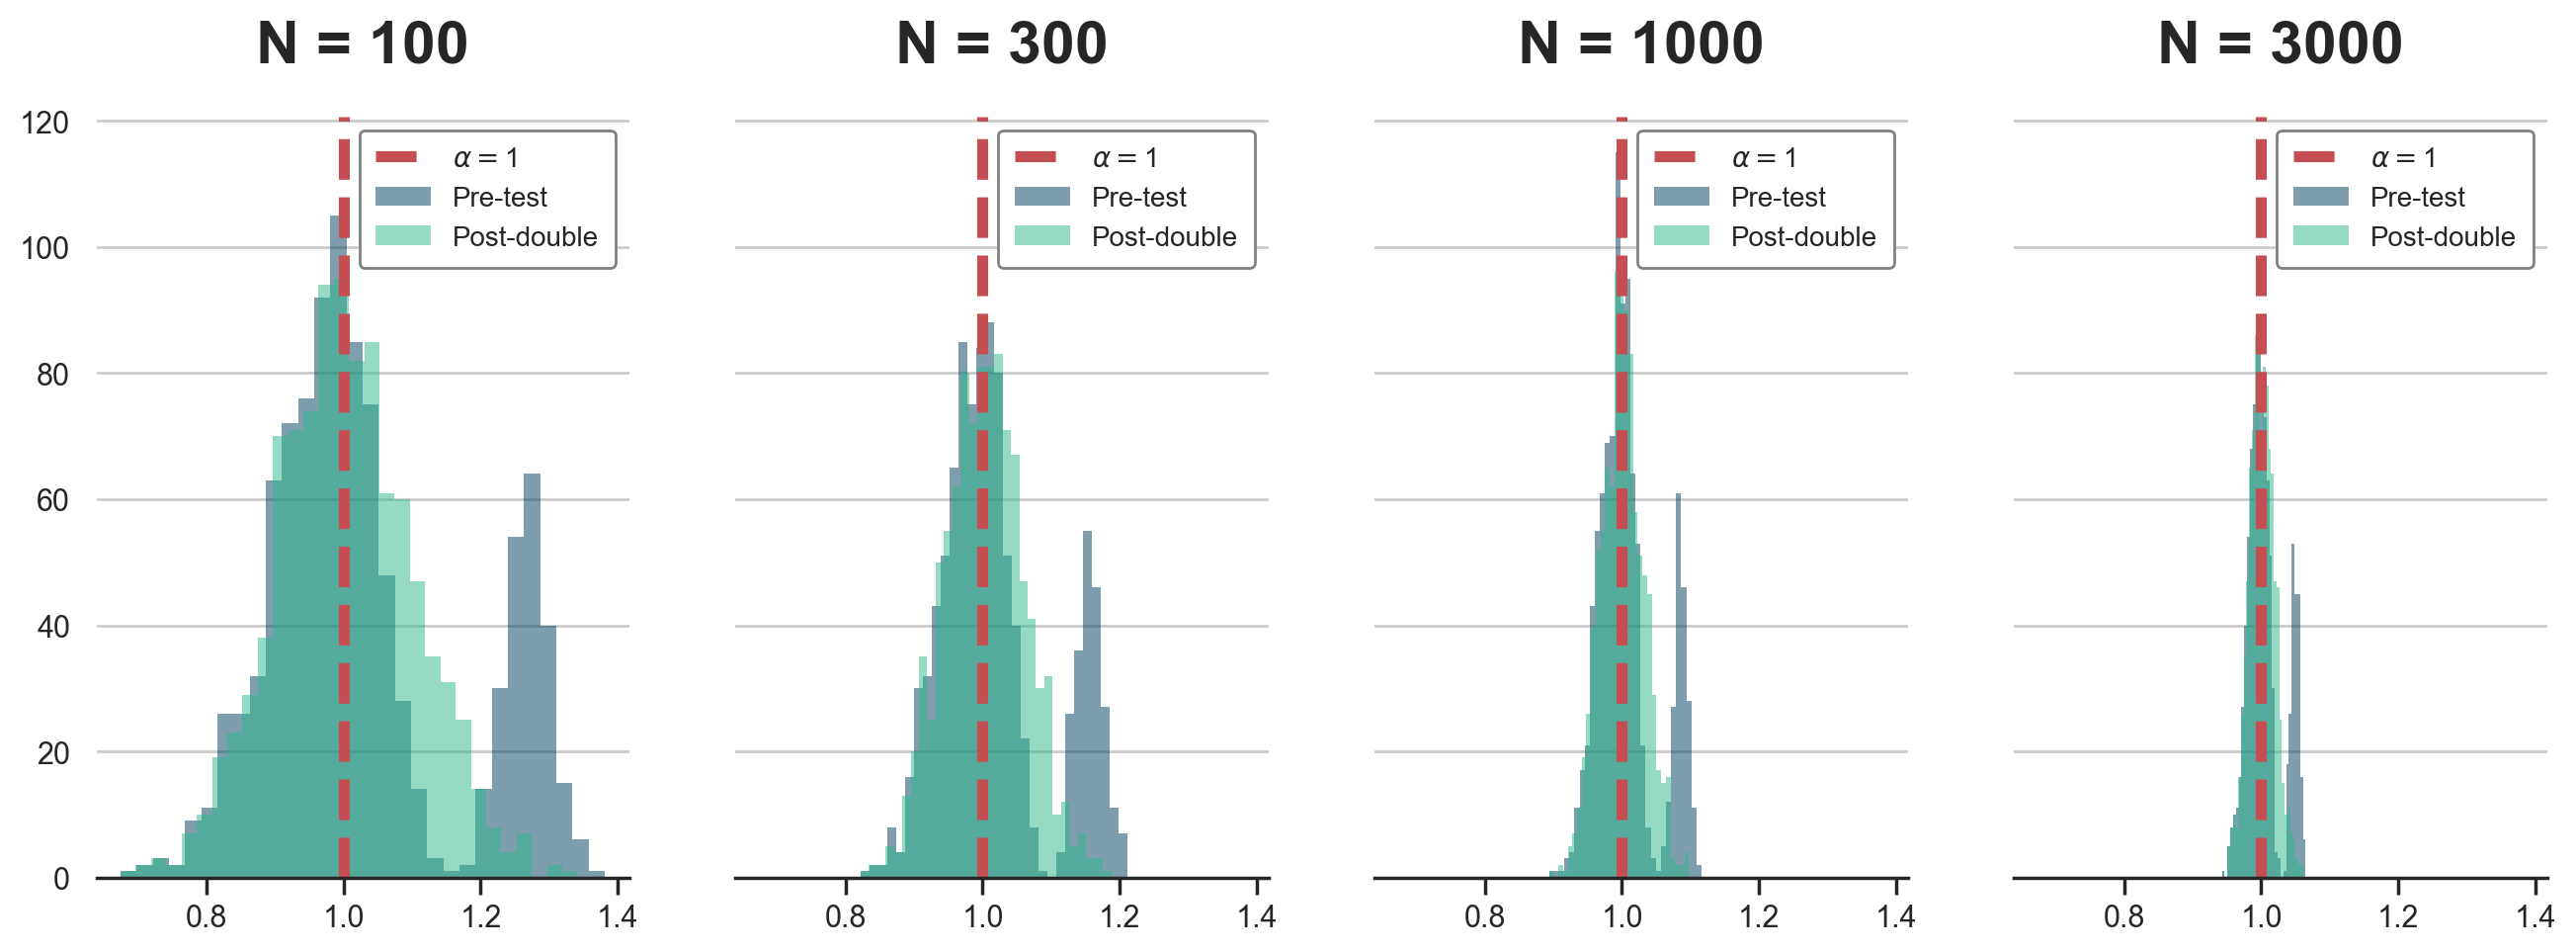

In [33]:
betas = 0.3 * 30 / np.sqrt(Ns)
alphas = {f'N = {n:.0f}':  pre_test(b=b, N=n) for n,b in zip(Ns,betas)}
compare_alphas(alphas, true_alpha=1)

Também neste último caso, o estimador pós-seleção dupla tem um bom desempenho e a inferência não é distorcida.

### Aprendizado de Máquina com Duplo Desviés (*Double Debiased Machine Learning* - DDML)

Até agora, analisamos apenas um exemplo linear e univariado. O que acontece se a dimensão de $X$ aumenta e não sabemos a forma funcional através da qual $X$ afeta $Y$ e $D$? Nesses casos, podemos usar algoritmos de aprendizado de máquina para descobrir essas relações não lineares de alta dimensão.

**Chernozhukov, Chetverikov, Demirer, Duflo, Hansen, Newey e Robins (2018)** investigam esse cenário. Em particular, os autores consideram o seguinte modelo parcialmente linear (Semi-Paramétrico):

$$ Y = \alpha D + g(X) + u $$

$$ D = m(X) + v $$

onde $Y$ é a variável de resultado, $D$ o tratamento/Variável de interesse, e $X$ um conjunto potencialmente de alta dimensão de variáveis de controle.


***Ortogonalização***

Pelo teorema de Frisch-Waugh-Lovell, podemos estimar $\alpha$ a partir da parcialização direta do efeito de $X$ em $D$ 

$$v = D - m(X)$$

e de $X$ em $Y$ 

$$u = Y - g(X)$$

O objetivo do procedimento de ortogonalização é estimar com consistência o parâmetro causal $\alpha$ mesmo quando $D$ é correlacionado com os regressores $X$. Para isso, remove-se o componente previsível de $D$ e $Y$ em relação a $X$ separadamente, garantindo que a estimação final se baseie apenas na variação exógena de $D$. Em outras palavras, ao estimarmos os resíduos dessas regressões parciais, isolamos a parte de $D$ que é ortogonal a $X$, e usamos essa variação exógena para estimar o efeito causal de $D$ sobre $Y$.

Procedimento geral:

1. Divida a amostra em duas: amostra principal e auxiliar.
2. Use a ***amostra auxiliar*** para estimar $\hat{g}(X)$ de
$$ Y = g(X) + u $$

3. Use a ***amostra auxiliar*** para estimar $\hat{m}(X)$ de 
$$ D = m(X) + v $$

4. Use a amostra principal para calcular os componentes ortogonalizados:
$$ \hat{v} = D - \hat{m}(X) $$

$$ \hat{u} = Y - \hat{g}(X) $$

5. Use a amostra principal para estimar o estimador OLS duplamente residualizado como 

$$ \hat{\alpha} = (\hat{v´}D)^{-1}\hat{v´}(Y- \hat{g}(X)) $$

ou seja, o coeficiente é obtido pelo OLS simples dos resíduos, após retirarmos os efeitos de X:

$$ \hat{u} = \alpha \hat{v} + \epsilon $$


O estimador ***é consistente em raiz N***. Isso significa que não apenas o estimador converge para o valor verdadeiro à medida que o tamanho da amostra aumenta (ou seja, é consistente), mas também seu desvio padrão (ou seja, é consistente em raiz N).

A divisão da amostra introduz variabilidade adicional e reduz a eficiência da estimativa, já que apenas parte da amostra é usada em cada etapa. Para recuperar a taxa ótima de convergência $\sqrt{N}$, é comum aplicar cross-fitting, ou seja, trocar os papéis entre amostra auxiliar e principal, estimar novamente $\hat{\alpha}$ e, por fim, tomar a média das estimativas.

Exemplo do procedimento de ortogonalização:

In [53]:
m_y = smf.ols("sales ~  1 + Manag", data=df).fit()
df['resid_y'] = df['sales'] - m_y.predict(df)

In [54]:
m_D = smf.ols("ads ~ 1 + Manag", data=df).fit()
df['resid_D'] = df['ads'] - m_D.predict(df)

In [55]:
smf.ols("resid_y ~ resid_D", df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.16e-15,0.031,-2.01e-13,1.000,-0.060,0.060
resid_D,0.9708,0.030,32.561,0.000,0.912,1.029


Vamos comparar com a regressão OLS padrão:

In [56]:
smf.ols('sales ~ ads + Manag', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1405,0.185,0.758,0.448,-0.223,0.504
ads,0.9708,0.030,32.545,0.000,0.912,1.029
Manag,0.3381,0.095,3.543,0.000,0.151,0.525


Realmente, o procedimento de ortogonalização recupera o mesmo coeficiente que a regressão OLS padrão. Podemos generalizar para estrutura semi-paramétrica.

***Possivel ponto negativo do DDML***

O problema está relacionado a variáveis ​​de controle ruins (***bad controls***) . Ao condicionar a análise a características adicionais nem sempre é bom para a inferência causal. Dependendo do cenário, pode haver variáveis ​​que queremos deixar de fora da nossa análise, pois sua inclusão pode enviesar o coeficiente de interesse, impedindo uma interpretação causal. O exemplo mais simples são as variáveis ​​que são ***resultados comuns, tanto do tratamento quanto do resultado***.

O modelo de aprendizagem de máquina com duplo desviés pressupõe implicitamente que as variáveis ​​de controle $X$ são causas (fracamente) comuns tanto para o resultado $Y$ e o tratamento $D$ (*backdoor condition*). Se for esse o caso e não existir mais nenhuma relação mediada/indireta entre $X$ e $Y$, não há problema. 

Porém, se, por exemplo, alguma variável entre os controles $X$ ***é um efeito comum em vez de uma causa comum***, sua inclusão distorcerá o coeficiente de interesse. Além disso, é provável que essa variável esteja altamente correlacionada com o resultado $Y$ ou com o tratamento $D$. No último caso, isso implica que a seleção pós-dupla pode incluí-la em casos em que a seleção simples não a teria incluído. Portanto, ***na presença de variáveis ​​de controle ruins, o aprendizado de máquina com viés duplo pode ser ainda pior do que o pré-teste simples***.

**Por fim, como em qualquer método, é crucial ter uma compreensão clara das premissas do método e sempre verificar possíveis violações.**


### Aplicação em Python

Vamos utilizar a biblioteca EconML para aplicar o método DDML mais moderno, para estimar o efeito do ano adicional no campeonato de baisebol na renda dos jogadores de beisebol. A ideia é tentar isolar esse efeito e controlar por outras variáveis que podem influenciar a renda dos jogadores, e também a permanência nos campeonatos.

$$ Y = \alpha D + g(X) + u $$
$$ D = m(X) + v $$

In [58]:
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']

In [61]:
# --------------------
# Carregando os dados
# --------------------
X_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_train.csv').dropna()[features]

In [64]:
X_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_test.csv').dropna()[features]

In [67]:
y_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_train.csv').dropna()['x']

In [70]:
y_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_test.csv').dropna()['x']

In [81]:
from econml.dml import DML
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

X = X_train[['Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']].values
T = X_train['Years'].values
y = y_train.values

est = DML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestRegressor(),
    model_final=StatsModelsLinearRegression(fit_intercept=False),
    discrete_treatment=False
)
est.fit(y, T, X=X, W=None)

In [80]:
print(est.summary())

                  Coefficient Results                   
   point_estimate stderr zstat  pvalue ci_lower ci_upper
--------------------------------------------------------
X0         -1.197  0.728 -1.643    0.1   -2.625    0.231
X1          1.944  0.752  2.585   0.01     0.47    3.417
X2         -0.039  0.028  -1.38  0.168   -0.094    0.016
X3         -0.194  0.372 -0.522  0.601   -0.924    0.535
X4           1.13  0.743  1.521  0.128   -0.326    2.587
X5          0.204   0.18  1.131  0.258   -0.149    0.556
X6          -3.83  1.643 -2.331   0.02   -7.051    -0.61
                       CATE Intercept Results                      
               point_estimate stderr zstat pvalue ci_lower ci_upper
-------------------------------------------------------------------
cate_intercept         -1.796 16.268 -0.11  0.912   -33.68   30.088
-------------------------------------------------------------------

<sub>A linear parametric conditional average treatment effect (CATE) model was fitted:
$Y

In [78]:
import statsmodels.api as sm
import numpy as np

# Empilhando T (tratamento) com os controles X
X_full = np.column_stack([T, X])

# Adicionando constante (intercepto)
X_full = sm.add_constant(X_full)

# Regressão OLS
ols_model = sm.OLS(y, X_full)
ols_results = ols_model.fit()

# Exibindo o resumo
print(ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     21.28
Date:                seg, 30 jun 2025   Prob (F-statistic):           5.39e-20
Time:                        19:35:01   Log-Likelihood:                -933.10
No. Observations:                 132   AIC:                             1884.
Df Residuals:                     123   BIC:                             1910.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -252.9656     95.523     -2.648      0.0

In [ ]:
# Load Acemoglu Johnson Robinson Dataset
df = pd.read_csv('data/AJR02.csv',index_col=0)
df.head()

Em seu artigo, a AJR observa que sua estratégia de IV será invalidada se outros fatores também forem altamente persistentes e relacionados ao desenvolvimento das instituições dentro de um país e ao PIB do país. Um dos principais candidatos a tal fator, como eles discutem, é a geografia. A AJR aborda isso assumindo que o efeito de confusão da geografia é adequadamente capturado por um termo linear de distância do equador e um conjunto de variáveis ​​fictícias continentais.

Eles incluem seus resultados na tabela 2.

In [ ]:
df.info()

In [ ]:
# Add constant term to dataset
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = df[['const', 'Exprop']]
X2 = df[['const', 'Exprop', 'Latitude', 'Latitude2']]
X3 = df[['const', 'Exprop', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']]
y = df['GDP']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(y, X1, missing='drop').fit()
reg2 = sm.OLS(y, X2, missing='drop').fit()
reg3 = sm.OLS(y, X3, missing='drop').fit()

In [ ]:
# Make table 2
def make_table_2():

    info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

    results_table = summary_col(results=[reg1,reg2,reg3],
                                float_format='%0.2f',
                                stars = True,
                                model_names=['Model 1','Model 2','Model 3'],
                                info_dict=info_dict,
                                regressor_order=['const','Exprop','Latitude','Latitude2'])
    return results_table

In [ ]:
table_2 = make_table_2()
table_2

Usar DDML nos permite relaxar essa suposição e substituí-la por uma suposição mais fraca de que a geografia pode ser suficientemente controlada por uma função desconhecida de distância do equador e de modelos continentais, o que pode ser aprendido por métodos de ML.

Em particular, a nossa estrutura é


Para que o procedimento de aprendizagem de máquina duplo/desviés seja

Divida a amostra em duas: amostra principal e amostra auxiliar

Use a amostra auxiliar para estimar
de


Use a amostra auxiliar para estimar
de


Use a amostra principal para calcular o componente ortogonalizado de
sobre
como


Use a amostra principal para estimar o estimador OLS duplamente residualizado como

$$ \hat{\beta} {0}=\left(\frac{1}{n} \sum {i \in I} \hat v_i \times {Exprop} {i} \right)^{-1} \frac{1}{n} \sum {i \in I} \hat v_i \times \left( {PIB} - \hat g_0({geografia}) \right) $$

Como empregamos uma estratégia de variável instrumental , substituímos
com
no primeiro estágio.

In [ ]:
# Generate variables
D = df['Exprop'].values.reshape(-1,1)
X = df[['const', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']].values
y = df['GDP'].values.reshape(-1,1)
Z = df[['const', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer','logMort']].values

In [ ]:
def estimate_beta(algorithm, alg_name, D, X, y, Z, sample):

    # Split sample
    D_main, D_aux = (D[sample==1], D[sample==0])
    X_main, X_aux = (X[sample==1], X[sample==0])
    y_main, y_aux = (y[sample==1], y[sample==0])
    Z_main, Z_aux = (Z[sample==1], Z[sample==0])

    # Residualize y on D
    b_hat = inv(D_aux.T @ D_aux) @ D_aux.T @ y_aux
    y_resid_aux = y_aux - D_aux @ b_hat
    
    # Estimate g0
    alg_fitted = algorithm.fit(X=X_aux, y=y_resid_aux.ravel())
    g0 = alg_fitted.predict(X_main).reshape(-1,1)

    # Compute v_hat
    u_hat = y_main - g0

    # Estimate m0
    alg_fitted = algorithm.fit(X=Z_aux, y=D_aux.ravel())
    m0 = algorithm.predict(Z_main).reshape(-1,1)
    
    # Compute u_hat
    v_hat = D_main - m0

    # Estimate beta
    beta = inv(v_hat.T @ D_main) @ v_hat.T @ u_hat
        
    return beta 

In [ ]:
def ddml(algorithm, alg_name, D, X, y, Z, p=0.5, verbose=False):
    
    # Expand X if Lasso or Ridge
    if alg_name in ['Lasso   ','Ridge   ']:
        X = PolynomialFeatures(degree=2).fit_transform(X)

    # Generate split (fixed proportions)
    split = np.array([i in train_test_split(range(len(D)), test_size=p)[0] for i in range(len(D))])
    
    # Compute beta
    beta = [estimate_beta(algorithm, alg_name, D, X, y, Z, split==k) for k in range(2)]
    beta = np.mean(beta)
     
    # Print and return
    if verbose:
        print('%s : %.4f' % (alg_name, beta))
    return beta

In [ ]:
# Generate sample split
p = 0.5
split = np.random.binomial(1, p, len(D))

Inspecionamos diferentes algoritmos. Em particular, consideramos:

Regressão Lasso
Regressão de Ridge
Árvores de Regressão
Floresta aleatória
Florestas Impulsionadas

In [ ]:
# List all algorithms
algorithms = {'Ridge   ': Ridge(alpha=.1),
              'Lasso   ': Lasso(alpha=.01),
              'Tree    ': DecisionTreeRegressor(),
              'Forest  ': RandomForestRegressor(n_estimators=30),
              'Boosting': GradientBoostingRegressor(n_estimators=30)}

Vamos comparar os resultados.

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, Z, verbose=True)

Os resultados são extremamente voláteis.

In [ ]:
# Repeat K times
def estimate_beta_median(algorithms, D, X, y, Z, K):
    
    # Loop over algorithms
    for alg_name, algorithm in algorithms.items():
        betas = []
            
        # Iterate n times
        for k in range(K):
            beta = ddml(algorithm, alg_name, D, X, y, Z)
            betas = np.append(betas, beta)
    
        print('%s : %.4f' % (alg_name, np.median(betas)))

Vamos tentar usar a mediana para ter um estimador mais estável.

In [ ]:
np.random.seed(123)

# Repeat 100 times and take median
estimate_beta_median(algorithms, D, X, y, Z, 100)

Os resultados diferem um pouco dos do artigo, mas pelo menos são mais próximos.

In [1]:
# Pacotes
import numpy as np
import pandas as pd
import plotnine as p
import statsmodels.api as sm
import linearmodels as lm
import statsmodels.formula.api as smf 
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col

In [2]:
# Carregar a base de dados
data = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/bacon_example.dta")

In [ ]:
# Filtragem dos dados
# Vamos criar identificadores estaduais
data['id'] = data['stfips'].rank(method='dense').astype(int)

# Criar uma nova variável de tempo "time"
data['time'] = data['year'] - 1963

# Time to treatment
data['year_treated'] = data['_nfd']
data['time_to_treatment'] = data['year'] - data['year_treated'] + 1

# Outcome (Suicide Mortality)
data['Y'] = data['asmrs']
# Treatment
data['D'] = data['post']
# Covariáveis - pcinc asmrh cases
data['X1'] = data['pcinc']
data['X2'] = data['asmrh']
data['X3'] = data['cases']


data['media_D'] = data.groupby('id')['D'].transform('mean')
data['always_treated'] = np.where(data['media_D'] == 1, 1, 0)
data['never_treated'] = np.where(data['media_D'] == 0, 1, 0)

# Vamos criar a variável de grupo G
data['G']=data['_nfd']



In [15]:
data

stfips    year    _nfd  post      asmrs         pcinc     asmrh  \
id1 year1                                                                    
1   1964        1  1964.0  1971.0   0.0  35.639885  12406.178537  5.007341   
    1965        1  1965.0  1971.0   0.0  41.543755  13070.206738  4.425367   
    1966        1  1966.0  1971.0   0.0  34.252335  13526.663217  4.874819   
    1967        1  1967.0  1971.0   0.0  34.465023  13918.189823  5.362014   
    1968        1  1968.0  1971.0   0.0  40.440105  14684.808682  4.643759   
...           ...     ...     ...   ...        ...           ...       ...   
49  1992       56  1992.0  1977.0   1.0  33.149574  31181.450546  1.970134   
    1993       56  1993.0  1977.0   1.0  63.909775  31666.776231  3.020953   
    1994       56  1994.0  1977.0   1.0  81.793816  31959.528356  3.501871   
    1995       56  1995.0  1977.0   1.0  30.630585  32327.659531  0.740606   
    1996       56  1996.0  1977.0   1.0  49.669003  32667.248279  2.663140   

              cases        weight         copop  ...    D            X1  \
id1 year1                                        ...                      
1   1964   0.012312  1.715156e+06  1.715156e+06  ...  0.0  12406.178537   
    1965   0.010419  1.715156e+06  1.725186e+06  ...  0.0  13070.206738   
    1966   0.009900  1.715156e+06  1.735219e+06  ...  0.0  13526.663217   
    1967   0.009975  1.715156e+06  1.745250e+06  ...  0.0  13918.189823   
    1968   0.012401  1.715156e+06  1.755283e+06  ...  0.0  14684.808682   
...             ...           ...           ...  ...  ...           ...   
49  1992   0.028996  1.621688e+05  2.323830e+05  ...  1.0  31181.450546   
    1993   0.026672  1.621688e+05  2.355600e+05  ...  1.0  31666.776231   
    1994   0.023643  1.621688e+05  2.389800e+05  ...  1.0  31959.528356   
    1995   0.020965  1.621688e+05  2.414090e+05  ...  1.0  32327.659531   
    1996   0.018639  1.621688e+05  2.429100e+05  ...  1.0  32667.248279   

                 X2        X3   media_D  always_treated  never_treated  \
id1 year1                                                                
1   1964   5.007341  0.012312  0.787879               0              0   
    1965   4.425367  0.010419  0.787879               0              0   
    1966   4.874819  0.009900  0.787879               0              0   
    1967   5.362014  0.009975  0.787879               0              0   
    1968   4.643759  0.012401  0.787879               0              0   
...             ...       ...       ...             ...            ...   
49  1992   1.970134  0.028996  0.606061               0              0   
    1993   3.020953  0.026672  0.606061               0              0   
    1994   3.501871  0.023643  0.606061               0              0   
    1995   0.740606  0.020965  0.606061               0              0   
    1996   2.663140  0.018639  0.606061               0              0   

           time_to_treatment  year_treated       G  
id1 year1                                           
1   1964                -6.0        1971.0  1971.0  
    1965                -5.0        1971.0  1971.0  
    1966                -4.0        1971.0  1971.0  
    1967                -3.0        1971.0  1971.0  
    1968                -2.0        1971.0  1971.0  
...                      ...           ...     ...  
49  1992                16.0        1977.0  1977.0  
    1993                17.0        1977.0  1977.0  
    1994                18.0        1977.0  1977.0  
    1995                19.0        1977.0  1977.0  
    1996                20.0        1977.0  1977.0  

[1617 rows x 23 columns]

In [16]:
# estrutura de painel dos dados. Precisamos ajustar a variável year para int (inteiro)
# Criando clones
data['year1'] = data['year']
data['id1'] = data['id']
data['year1'] = data['year'].astype(int)

# Definir os indices (estrutura de painel)
data.set_index(['id1', 'year1'], inplace=True)

In [18]:
import pandas as pd
from differences import ATTgt
import numpy as np

In [19]:
att_gt = ATTgt(data=data, cohort_name="G")

In [20]:
att_gt.fit("Y ~ X1", est_method="dr")

Computing ATTgt [workers=1]   100%|████████████████████| 384/384 [00:04<00:00, 93.44it/s] 


ATTgtResult                                            \
                                     analytic pointwise conf. band              
                                ATT std_error                lower      upper   
cohort base_period time                                                         
1969   1964        1965   -6.070418  8.259573           -22.258884  10.118048   
       1965        1966    6.174149  9.094903           -11.651533  23.999831   
       1966        1967    5.848175  3.752705            -1.506991  13.203342   
       1967        1968    2.036093  2.414729            -2.696688   6.768875   
       1968        1969    1.558169  4.865841            -7.978705  11.095043   
...                             ...       ...                  ...        ...   
1985   1984        1992   19.930538  4.051701            11.989349  27.871726   
                   1993   16.124177  2.333263            11.551066  20.697287   
                   1994   11.830665  2.834945             6.274274  17.387055   
                   1995    8.493860  2.493009             3.607652  13.380068   
                   1996   20.431504  4.480529            11.649828  29.213179   

                                           
                                           
                        zero_not_in_cband  
cohort base_period time                    
1969   1964        1965                    
       1965        1966                    
       1966        1967                    
       1967        1968                    
       1968        1969                    
...                                   ...  
1985   1984        1992                 *  
                   1993                 *  
                   1994                 *  
                   1995                 *  
                   1996                 *  

[384 rows x 5 columns]

In [21]:
att_gt.aggregate("simple")

SimpleAggregation                                                           
                     analytic pointwise conf. band                            
                ATT std_error                lower     upper zero_not_in_cband
0         -5.983104  3.130347           -12.118472  0.152264

In [22]:
att_gt.aggregate("event")

EventAggregation                                             \
                                   analytic pointwise conf. band              
                             ATT  std_error                lower      upper   
relative_period                                                               
-20                    -5.033935   3.389414           -11.677064   1.609194   
-19                    20.493741  15.162160            -9.223546  50.211027   
-18                   -16.704148   7.497377           -31.398738  -2.009559   
-17                     6.379153  10.724160           -14.639815  27.398121   
-16                     0.227519   5.676934           -10.899067  11.354106   
-15                     1.996730   5.853899            -9.476702  13.470162   
-14                     1.966673   3.972759            -5.819790   9.753137   
-13                     1.981498   5.786478            -9.359792  13.322787   
-12                    -4.305008   8.346027           -20.662921  12.052905   
-11                   -12.235455   7.406652           -26.752226   2.281317   
-10                    12.658956   6.745294            -0.561577  25.879489   
-9                     -8.502006   4.483655           -17.289809   0.285796   
-8                      2.087717   2.709509            -3.222824   7.398258   
-7                     -0.561912   3.277482            -6.985659   5.861835   
-6                      1.489753   3.421874            -5.216996   8.196502   
-5                     -2.400586   2.678888            -7.651110   2.849938   
-4                      3.071620   2.164289            -1.170308   7.313548   
-3                      0.273076   2.473907            -4.575692   5.121844   
-2                      0.375515   2.706088            -4.928321   5.679351   
-1                      0.897422   2.960048            -4.904165   6.699010   
 0                     -1.025316   2.684484            -6.286808   4.236176   
 1                     -1.924231   3.206853            -8.209548   4.361087   
 2                     -3.342883   3.887112           -10.961482   4.275716   
 3                     -2.098534   2.944012            -7.868691   3.671622   
 4                     -3.398965   2.720592            -8.731228   1.933297   
 5                     -4.233076   3.248700           -10.600410   2.134259   
 6                     -4.123248   3.441458           -10.868381   2.621886   
 7                     -6.625254   3.938525           -14.344621   1.094113   
 8                     -7.242188   3.076394           -13.271809  -1.212566   
 9                     -3.863612   4.015843           -11.734519   4.007296   
 10                    -7.074051   4.059642           -15.030804   0.882702   
 11                    -4.193251   4.396948           -12.811111   4.424609   
 12                    -3.624977   4.172082           -11.802108   4.552154   
 13                    -5.242709   4.489746           -14.042450   3.557032   
 14                    -4.248161   4.679667           -13.420139   4.923818   
 15                    -6.474832   4.595357           -15.481567   2.531903   
 16                    -5.952079   4.229266           -14.241288   2.337130   
 17                    -7.172010   4.582262           -16.153079   1.809059   
 18                    -8.961597   4.027966           -16.856264  -1.066929   
 19                   -10.507467   3.690032           -17.739797  -3.275137   
 20                    -8.203524   4.103070           -16.245395  -0.161654   
 21                    -9.381068   3.973210           -17.168417  -1.593719   
 22                   -10.708308   3.914203           -18.380005  -3.036611   
 23                   -12.198167   4.139249           -20.310946  -4.085387   
 24                   -13.166945   4.942369           -22.853811  -3.480079   
 25                   -13.419991   6.880288           -26.905108   0.065126   
 26                   -22.371152  11.263488           -44.447182  

In [25]:
# Pacotes
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Filtrar apenas grupos tratados e nunca tratados
data_cf = data[(data['never_treated'] == 1) | (data['always_treated'] == 0)]

# Definir variáveis
Y = data_cf['Y'].values
T = data_cf['D'].astype(int).values
X = data_cf[['X1', 'X2', 'X3']].values

# Padronizar as covariáveis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Estimar Causal Forest
causal_forest = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
    model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
    n_estimators=500,
    min_samples_leaf=5,
    max_depth=10,
    verbose=1,
    random_state=42
)

causal_forest.fit(Y, T, X=X_scaled)

# Estimar efeito médio do tratamento (ATE)
ate = causal_forest.ate_
print(f"ATE: {ate:.4f}")

# Estimar CATEs individuais
cate_preds = causal_forest.effect(X_scaled)

# Adicionar os efeitos de tratamento ao DataFrame
data_cf['CATE'] = cate_preds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


AttributeError: Doubly Robust ATE calculation on training data is available only on discrete treatments!

In [24]:
data_cf

stfips    year    _nfd  post      asmrs         pcinc     asmrh  \
id1 year1                                                                    
1   1964        1  1964.0  1971.0   0.0  35.639885  12406.178537  5.007341   
    1965        1  1965.0  1971.0   0.0  41.543755  13070.206738  4.425367   
    1966        1  1966.0  1971.0   0.0  34.252335  13526.663217  4.874819   
    1967        1  1967.0  1971.0   0.0  34.465023  13918.189823  5.362014   
    1968        1  1968.0  1971.0   0.0  40.440105  14684.808682  4.643759   
...           ...     ...     ...   ...        ...           ...       ...   
49  1992       56  1992.0  1977.0   1.0  33.149574  31181.450546  1.970134   
    1993       56  1993.0  1977.0   1.0  63.909775  31666.776231  3.020953   
    1994       56  1994.0  1977.0   1.0  81.793816  31959.528356  3.501871   
    1995       56  1995.0  1977.0   1.0  30.630585  32327.659531  0.740606   
    1996       56  1996.0  1977.0   1.0  49.669003  32667.248279  2.663140   

              cases        weight         copop  ...    D            X1  \
id1 year1                                        ...                      
1   1964   0.012312  1.715156e+06  1.715156e+06  ...  0.0  12406.178537   
    1965   0.010419  1.715156e+06  1.725186e+06  ...  0.0  13070.206738   
    1966   0.009900  1.715156e+06  1.735219e+06  ...  0.0  13526.663217   
    1967   0.009975  1.715156e+06  1.745250e+06  ...  0.0  13918.189823   
    1968   0.012401  1.715156e+06  1.755283e+06  ...  0.0  14684.808682   
...             ...           ...           ...  ...  ...           ...   
49  1992   0.028996  1.621688e+05  2.323830e+05  ...  1.0  31181.450546   
    1993   0.026672  1.621688e+05  2.355600e+05  ...  1.0  31666.776231   
    1994   0.023643  1.621688e+05  2.389800e+05  ...  1.0  31959.528356   
    1995   0.020965  1.621688e+05  2.414090e+05  ...  1.0  32327.659531   
    1996   0.018639  1.621688e+05  2.429100e+05  ...  1.0  32667.248279   

                 X2        X3   media_D  always_treated  never_treated  \
id1 year1                                                                
1   1964   5.007341  0.012312  0.787879               0              0   
    1965   4.425367  0.010419  0.787879               0              0   
    1966   4.874819  0.009900  0.787879               0              0   
    1967   5.362014  0.009975  0.787879               0              0   
    1968   4.643759  0.012401  0.787879               0              0   
...             ...       ...       ...             ...            ...   
49  1992   1.970134  0.028996  0.606061               0              0   
    1993   3.020953  0.026672  0.606061               0              0   
    1994   3.501871  0.023643  0.606061               0              0   
    1995   0.740606  0.020965  0.606061               0              0   
    1996   2.663140  0.018639  0.606061               0              0   

           time_to_treatment  year_treated       G  
id1 year1                                           
1   1964                -6.0        1971.0  1971.0  
    1965                -5.0        1971.0  1971.0  
    1966                -4.0        1971.0  1971.0  
    1967                -3.0        1971.0  1971.0  
    1968                -2.0        1971.0  1971.0  
...                      ...           ...     ...  
49  1992                16.0        1977.0  1977.0  
    1993                17.0        1977.0  1977.0  
    1994                18.0        1977.0  1977.0  
    1995                19.0        1977.0  1977.0  
    1996                20.0        1977.0  1977.0  

[1353 rows x 23 columns]